In [ ]:
# pip install torch torchvision

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


## Define

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import wandb


In [ ]:
class ConvBNActivation(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1, activation=nn.ReLU6):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )

class InvertedResidualBlock(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio, kernel_size=3, activation=nn.ReLU6):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1, activation=activation))
        layers += [
            ConvBNActivation(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, activation=activation, kernel_size=kernel_size),
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outp),
        ]
        self.conv_layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_shortcut:
            return x + self.conv_layers(x)
        else:
            return self.conv_layers(x)

class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, inverted_block_configs, first_layer_channels, expansion_layer_channels, dropout_rate=0.0, activation=nn.ReLU6):
        super().__init__()
        self.first_layer = ConvBNActivation(3, first_layer_channels, stride=2, activation=activation)
        self.inverted_blocks = nn.Sequential(
            *[InvertedResidualBlock(**cfg, activation=activation) for cfg in inverted_block_configs]
        )
        self.expansion_layer = ConvBNActivation(inverted_block_configs[-1]['outp'], expansion_layer_channels, kernel_size=1, activation=activation)
        self.dropout = nn.Dropout(p=dropout_rate)

        self.classifier = None
        self.num_classes = num_classes
        self._initialize_classifier(first_layer_channels, expansion_layer_channels, activation)

    def _initialize_classifier(self, first_layer_channels, expansion_layer_channels, activation):
        with torch.no_grad():
            dummy_input = torch.zeros(2, 3, 32, 32)
            x = self.first_layer(dummy_input)
            x = self.inverted_blocks(x)
            x = self.expansion_layer(x)
            x = x.view(x.size(0), -1)
            output_size = x.shape[1]

        self.classifier = nn.Linear(output_size, self.num_classes)


    def forward(self, x):
        if self.classifier is None:
            raise RuntimeError("Classifier has not been initialized.")
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.expansion_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x



In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def imshow_with_labels(images, labels, predictions=None):
    images = torchvision.utils.make_grid(images)
    images = images / 2 + 0.5  # unnormalize
    np_images = images.numpy()
    plt.imshow(np.transpose(np_images, (1, 2, 0)))
    title = 'True: ' + ' '.join(f'{classes[labels[j]]}' for j in range(4))
    if predictions is not None:
        title += '\nPred: ' + ' '.join(f'{classes[predictions[j]]}' for j in range(4))
    plt.title(title)
    plt.show()


In [ ]:
def train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += predicted.eq(target.view_as(predicted)).sum().item()
        total += target.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracy.append(accuracy)

    print(f'Train Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"train_loss": avg_loss, "train_accuracy": accuracy, "epoch": epoch})


In [ ]:
def evaluate_model(model, device, data_loader, epoch, eval_losses, eval_accuracy):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            total_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += predicted.eq(target.view_as(predicted)).sum().item()
            total += target.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    eval_losses.append(avg_loss)
    eval_accuracy.append(accuracy)

    print(f'Eval Epoch: {epoch}\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
    wandb.log({"eval_loss": avg_loss, "eval_accuracy": accuracy, "epoch": epoch})


In [ ]:
def plot_metrics(train_losses, train_accuracy, eval_losses, eval_accuracy):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    axs[0, 0].plot(train_losses, label="Training Loss")
    axs[0, 0].set_title("Training Loss")

    axs[0, 1].plot(train_accuracy, label="Training Accuracy")
    axs[0, 1].set_title("Training Accuracy")

    axs[1, 0].plot(eval_losses, label="Evaluation Loss")
    axs[1, 0].set_title("Evaluation Loss")

    axs[1, 1].plot(eval_accuracy, label="Evaluation Accuracy")
    axs[1, 1].set_title("Evaluation Accuracy")

    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def main(model, config, train_loader, test_loader, exp_name):
    with wandb.init(project="mobilenetv2_arch", config=config, name=exp_name) as run:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(device)
        if config["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

        scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"], gamma= config['scheduler_gamma'])

        train_losses, train_accuracy = [], []
        test_losses, test_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, test_loader, epoch, test_losses, test_accuracy)
            scheduler.step()

        torch.save(model.state_dict(), f'{exp_name}_state_dict.pth')

    plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)


In [ ]:
original_architecture = [
    # Layer 1
    {"inp": 32, "outp": 16, "stride": 1, "expand_ratio": 1},
    # Layer 2
    {"inp": 16, "outp": 24, "stride": 2, "expand_ratio": 6},
    # Layer 3
    {"inp": 24, "outp": 24, "stride": 1, "expand_ratio": 6},
    # Layer 4
    {"inp": 24, "outp": 32, "stride": 2, "expand_ratio": 6},
    # Layer 5
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 6
    {"inp": 32, "outp": 32, "stride": 1, "expand_ratio": 6},
    # Layer 7
    {"inp": 32, "outp": 64, "stride": 2, "expand_ratio": 6},
    # Layer 8
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 9
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 10
    {"inp": 64, "outp": 64, "stride": 1, "expand_ratio": 6},
    # Layer 11
    {"inp": 64, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 12
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 13
    {"inp": 96, "outp": 96, "stride": 1, "expand_ratio": 6},
    # Layer 14
    {"inp": 96, "outp": 160, "stride": 2, "expand_ratio": 6},
    # Layer 15
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 16
    {"inp": 160, "outp": 160, "stride": 1, "expand_ratio": 6},
    # Layer 17
    {"inp": 160, "outp": 320, "stride": 1, "expand_ratio": 6},
]


In [ ]:
configA = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 30,
    "optimizer": "Adam",
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "first_layer_channels": 32,
    "expansion_layer_channels": 1280
}

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=configA["batch_size"], shuffle=True)


cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=configA["batch_size"], shuffle=False)

100%|██████████| 170498071/170498071 [00:06<00:00, 26180002.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 1

wandb: Currently logged in as: malak-y17. Use `wandb login --relogin` to force relogin


cuda
Train Epoch: 1	Loss: 1.690087, Accuracy: 38.81%
Eval Epoch: 1	Loss: 1.403974, Accuracy: 49.00%
Train Epoch: 2	Loss: 1.326284, Accuracy: 52.25%
Eval Epoch: 2	Loss: 1.263187, Accuracy: 54.24%
Train Epoch: 3	Loss: 1.149994, Accuracy: 59.04%
Eval Epoch: 3	Loss: 1.151127, Accuracy: 58.49%
Train Epoch: 4	Loss: 1.033999, Accuracy: 63.29%
Eval Epoch: 4	Loss: 1.075011, Accuracy: 61.54%
Train Epoch: 5	Loss: 0.935202, Accuracy: 66.91%
Eval Epoch: 5	Loss: 1.074917, Accuracy: 61.76%
Train Epoch: 6	Loss: 0.850182, Accuracy: 69.92%
Eval Epoch: 6	Loss: 1.033977, Accuracy: 64.37%
Train Epoch: 7	Loss: 0.773250, Accuracy: 72.70%
Eval Epoch: 7	Loss: 1.030774, Accuracy: 65.15%
Train Epoch: 8	Loss: 0.712144, Accuracy: 74.82%
Eval Epoch: 8	Loss: 1.000611, Accuracy: 65.62%
Train Epoch: 9	Loss: 0.650164, Accuracy: 77.01%
Eval Epoch: 9	Loss: 1.025299, Accuracy: 65.77%
Train Epoch: 10	Loss: 0.598354, Accuracy: 78.63%
Eval Epoch: 10	Loss: 1.048144, Accuracy: 66.42%
Train Epoch: 11	Loss: 0.545109, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▅▆▆▇▇▇▇███▇█████████████████
eval_loss,▄▃▂▂▂▁▁▁▁▁▂▂▂▂▂▄▅▅▆▆▇▇▇▇▇█████
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇██████████████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,67.08
eval_loss,1.91413
train_accuracy,97.102
train_loss,0.08131


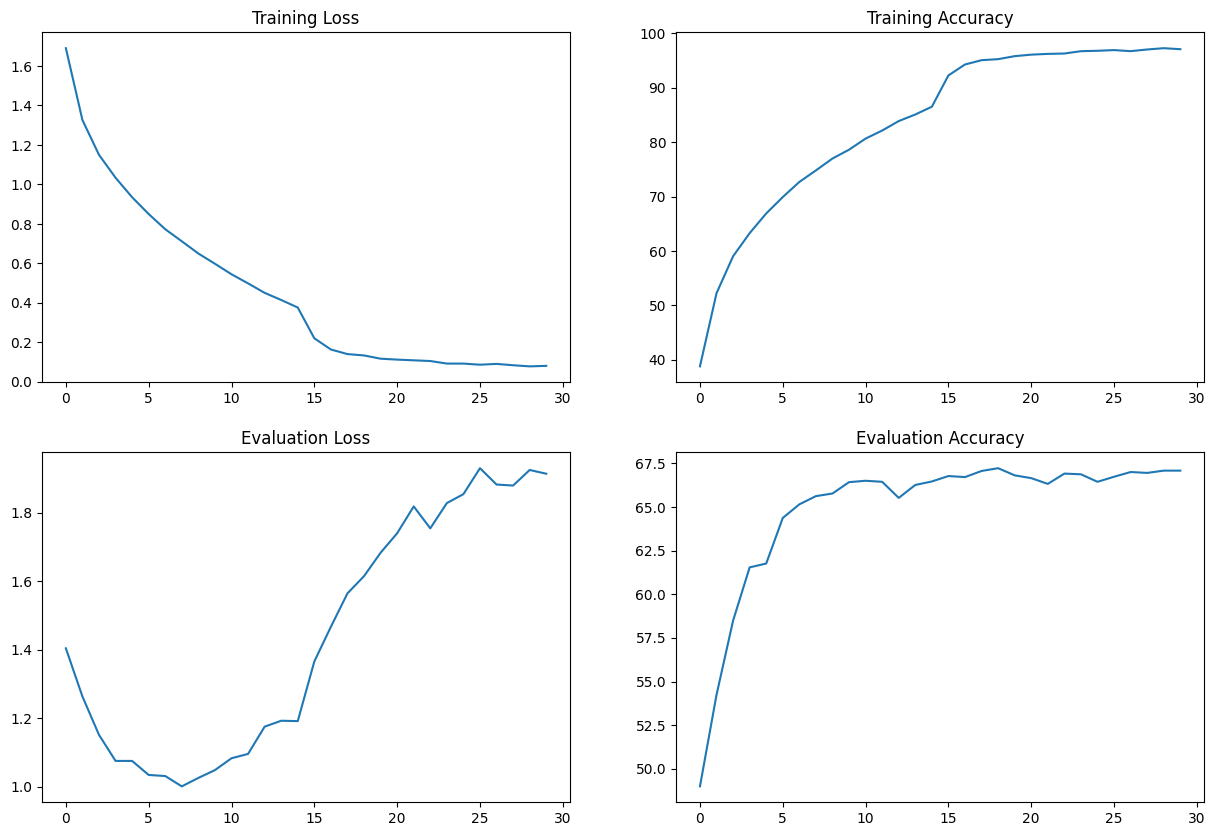

In [ ]:
modified_architecture_a = original_architecture[:10]

modelA = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_architecture_a,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)

main(modelA, configA, train_loader, test_loader, "modelA_exp")


Changing the expansion ratios in the inverted residual blocks.

cuda
Train Epoch: 1	Loss: 1.850318, Accuracy: 30.97%
Eval Epoch: 1	Loss: 1.565889, Accuracy: 41.73%
Train Epoch: 2	Loss: 1.482955, Accuracy: 45.54%
Eval Epoch: 2	Loss: 1.361441, Accuracy: 50.35%
Train Epoch: 3	Loss: 1.309088, Accuracy: 53.19%
Eval Epoch: 3	Loss: 1.264296, Accuracy: 55.38%
Train Epoch: 4	Loss: 1.182325, Accuracy: 58.19%
Eval Epoch: 4	Loss: 1.216707, Accuracy: 57.34%
Train Epoch: 5	Loss: 1.073919, Accuracy: 62.40%
Eval Epoch: 5	Loss: 1.121241, Accuracy: 60.71%
Train Epoch: 6	Loss: 0.977608, Accuracy: 66.00%
Eval Epoch: 6	Loss: 1.043065, Accuracy: 63.11%
Train Epoch: 7	Loss: 0.889053, Accuracy: 68.84%
Eval Epoch: 7	Loss: 1.037195, Accuracy: 63.94%
Train Epoch: 8	Loss: 0.812178, Accuracy: 71.90%
Eval Epoch: 8	Loss: 1.012660, Accuracy: 65.69%
Train Epoch: 9	Loss: 0.751083, Accuracy: 74.30%
Eval Epoch: 9	Loss: 0.978823, Accuracy: 66.94%
Train Epoch: 10	Loss: 0.693654, Accuracy: 76.11%
Eval Epoch: 10	Loss: 1.078638, Accuracy: 64.85%
Train Epoch: 11	Loss: 0.641865, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▇▇▇▇████████████████████
eval_loss,▇▅▄▄▃▂▂▂▁▂▁▁▂▂▂▂▄▄▅▅▆▇▆▇▇▇█▇██
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇█████████████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,68.77
eval_loss,1.58786
train_accuracy,96.75
train_loss,0.09628


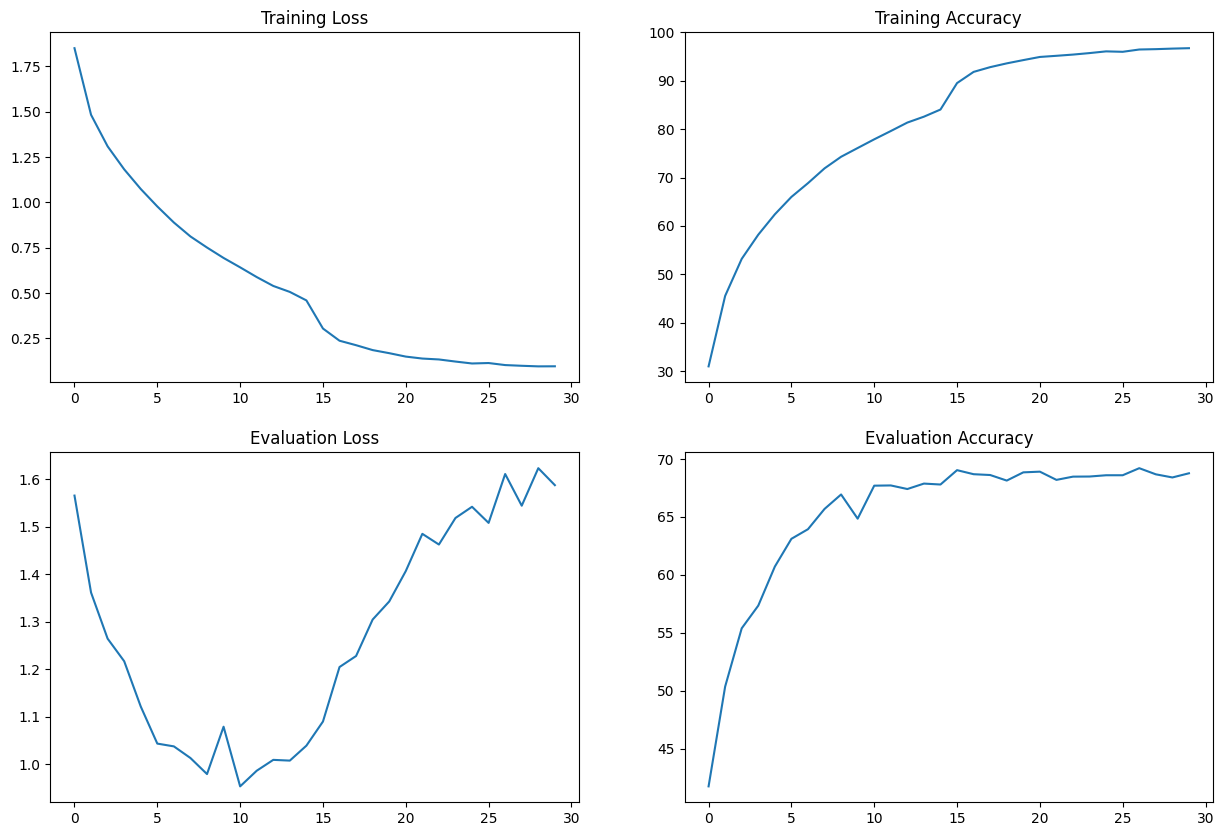

In [ ]:
modified_architecture_c = [dict(layer, expand_ratio=10 if layer['expand_ratio'] == 6 else layer['expand_ratio']) for layer in original_architecture]

modelC = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_architecture_c,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)

main(modelC, configA, train_loader, test_loader, "modelC_exp")

Trying another activation function, LeakyReLU

cuda
Train Epoch: 1	Loss: 1.958827, Accuracy: 26.75%
Eval Epoch: 1	Loss: 1.666043, Accuracy: 38.10%
Train Epoch: 2	Loss: 1.586006, Accuracy: 41.50%
Eval Epoch: 2	Loss: 1.512067, Accuracy: 44.36%
Train Epoch: 3	Loss: 1.419357, Accuracy: 48.66%
Eval Epoch: 3	Loss: 1.368148, Accuracy: 49.56%
Train Epoch: 4	Loss: 1.295897, Accuracy: 53.69%
Eval Epoch: 4	Loss: 1.274674, Accuracy: 54.33%
Train Epoch: 5	Loss: 1.186744, Accuracy: 57.69%
Eval Epoch: 5	Loss: 1.175787, Accuracy: 58.44%
Train Epoch: 6	Loss: 1.091369, Accuracy: 61.80%
Eval Epoch: 6	Loss: 1.130839, Accuracy: 60.45%
Train Epoch: 7	Loss: 1.005752, Accuracy: 64.59%
Eval Epoch: 7	Loss: 1.090993, Accuracy: 61.58%
Train Epoch: 8	Loss: 0.929257, Accuracy: 67.33%
Eval Epoch: 8	Loss: 1.049604, Accuracy: 64.05%
Train Epoch: 9	Loss: 0.861813, Accuracy: 69.77%
Eval Epoch: 9	Loss: 1.039952, Accuracy: 63.48%
Train Epoch: 10	Loss: 0.805236, Accuracy: 71.90%
Eval Epoch: 10	Loss: 1.028100, Accuracy: 64.91%
Train Epoch: 11	Loss: 0.750411, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇██████████████████
eval_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▂▂▃▃▄▅▅▅▆▆▆▆▇▇▇
train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████████
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,66.72
eval_loss,1.57126
train_accuracy,95.128
train_loss,0.13981


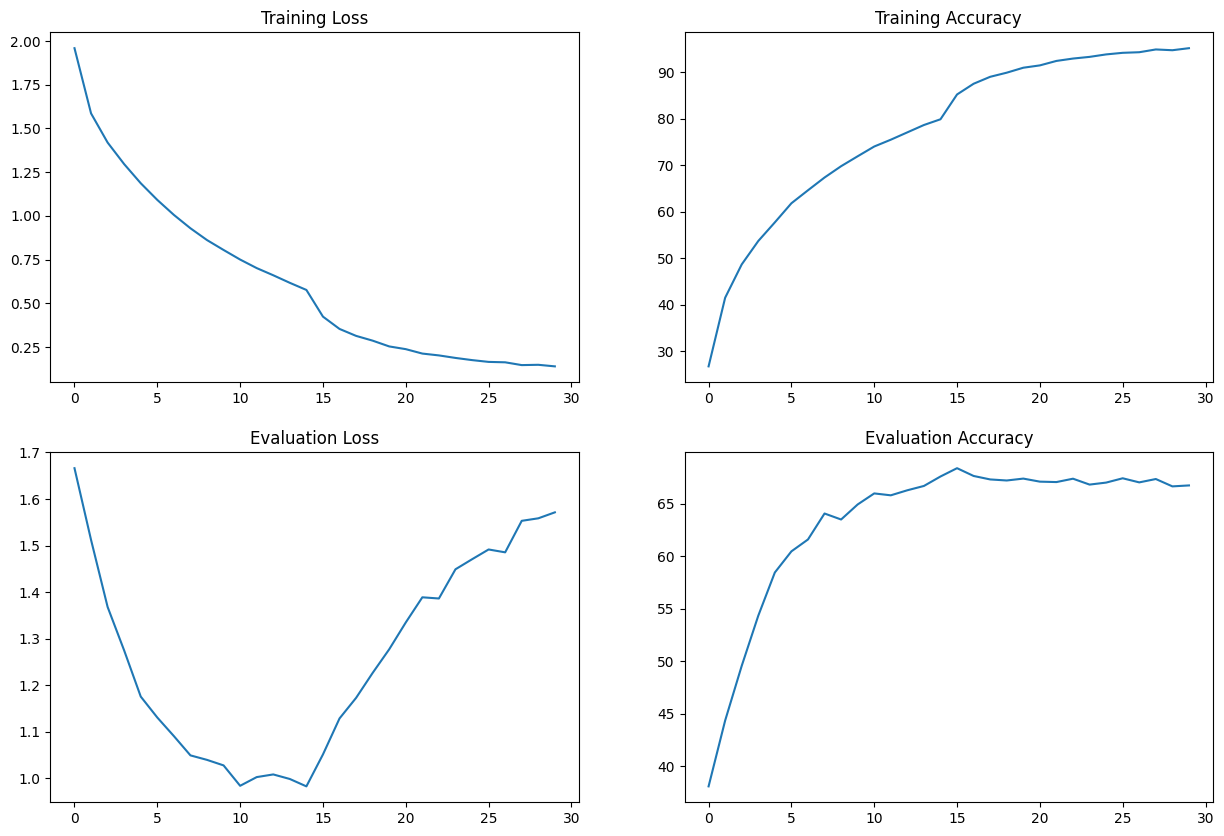

In [ ]:
modelLeakyRelu = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.LeakyReLU
)

main(modelLeakyRelu, configA, train_loader, test_loader, "LeakyRelu_exp")


cuda
Train Epoch: 1	Loss: 1.765869, Accuracy: 34.79%
Eval Epoch: 1	Loss: 1.450998, Accuracy: 46.80%
Train Epoch: 2	Loss: 1.385468, Accuracy: 50.20%
Eval Epoch: 2	Loss: 1.296788, Accuracy: 52.77%
Train Epoch: 3	Loss: 1.212417, Accuracy: 57.02%
Eval Epoch: 3	Loss: 1.163060, Accuracy: 58.26%
Train Epoch: 4	Loss: 1.073817, Accuracy: 62.32%
Eval Epoch: 4	Loss: 1.109282, Accuracy: 60.81%
Train Epoch: 5	Loss: 0.969934, Accuracy: 66.22%
Eval Epoch: 5	Loss: 1.053794, Accuracy: 62.90%
Train Epoch: 6	Loss: 0.881215, Accuracy: 69.71%
Eval Epoch: 6	Loss: 0.995425, Accuracy: 65.31%
Train Epoch: 7	Loss: 0.808719, Accuracy: 71.87%
Eval Epoch: 7	Loss: 0.972076, Accuracy: 66.11%
Train Epoch: 8	Loss: 0.749566, Accuracy: 74.12%
Eval Epoch: 8	Loss: 0.945899, Accuracy: 67.77%
Train Epoch: 9	Loss: 0.662444, Accuracy: 77.11%
Eval Epoch: 9	Loss: 0.963055, Accuracy: 67.96%
Train Epoch: 10	Loss: 0.624788, Accuracy: 78.24%
Eval Epoch: 10	Loss: 0.965773, Accuracy: 67.43%
Train Epoch: 11	Loss: 0.574703, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▅▅▆▇▇▇█▇▇███████████████████
eval_loss,▅▄▃▂▂▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▇▇▇▇▇████
train_accuracy,▁▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇██████████████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,68.39
eval_loss,1.72028
train_accuracy,97.05
train_loss,0.08669


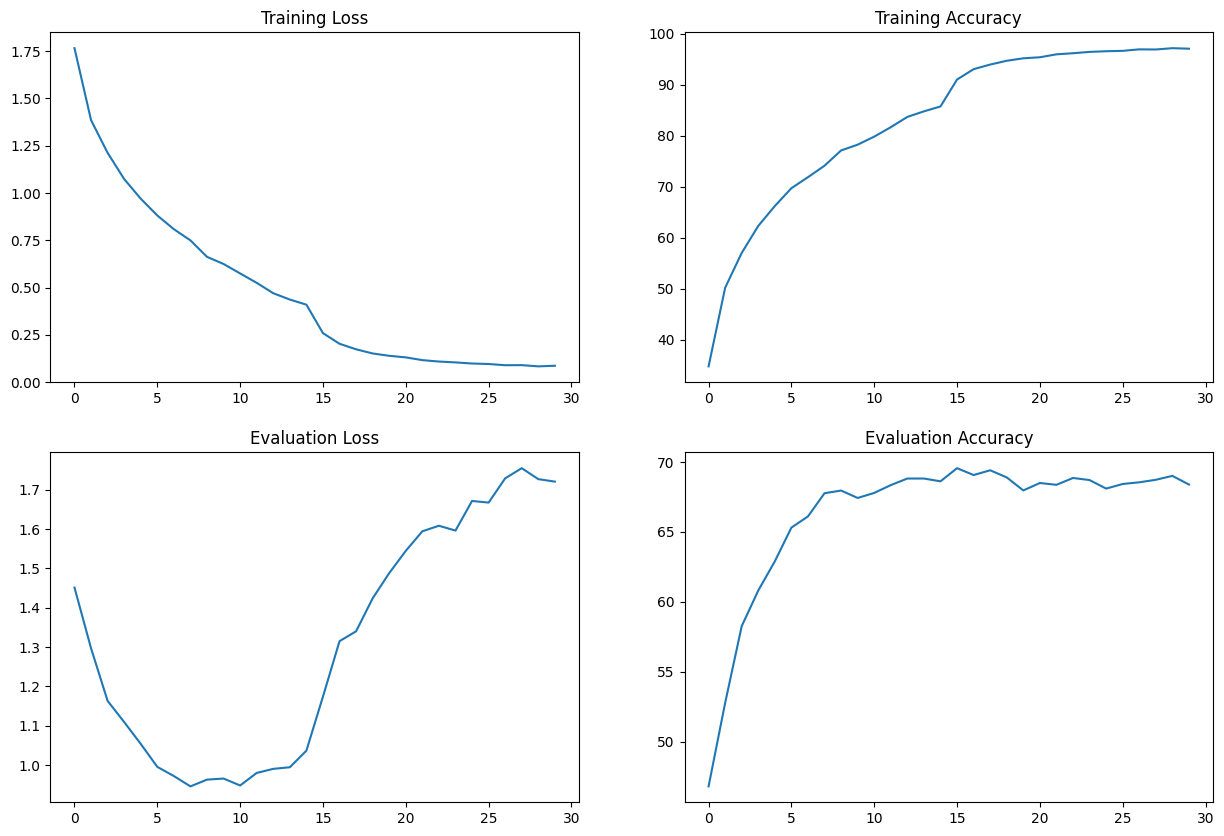

In [ ]:
modelSiLU = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.SiLU
)

main(modelSiLU, configA, train_loader, test_loader, "modelSiLU_exp")


cuda
Train Epoch: 1	Loss: 1.800494, Accuracy: 32.98%
Eval Epoch: 1	Loss: 1.523188, Accuracy: 44.34%
Train Epoch: 2	Loss: 1.458018, Accuracy: 46.77%
Eval Epoch: 2	Loss: 1.370801, Accuracy: 49.61%
Train Epoch: 3	Loss: 1.297988, Accuracy: 53.05%
Eval Epoch: 3	Loss: 1.262470, Accuracy: 54.23%
Train Epoch: 4	Loss: 1.181397, Accuracy: 57.76%
Eval Epoch: 4	Loss: 1.165140, Accuracy: 58.50%
Train Epoch: 5	Loss: 1.067458, Accuracy: 62.03%
Eval Epoch: 5	Loss: 1.113545, Accuracy: 59.78%
Train Epoch: 6	Loss: 0.976067, Accuracy: 65.47%
Eval Epoch: 6	Loss: 1.048549, Accuracy: 63.24%
Train Epoch: 7	Loss: 0.892819, Accuracy: 68.66%
Eval Epoch: 7	Loss: 1.026671, Accuracy: 63.96%
Train Epoch: 8	Loss: 0.809251, Accuracy: 71.43%
Eval Epoch: 8	Loss: 0.989899, Accuracy: 65.57%
Train Epoch: 9	Loss: 0.747056, Accuracy: 73.64%
Eval Epoch: 9	Loss: 0.992256, Accuracy: 65.62%
Train Epoch: 10	Loss: 0.687922, Accuracy: 75.96%
Eval Epoch: 10	Loss: 0.980977, Accuracy: 66.44%
Train Epoch: 11	Loss: 0.628945, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▇▇▇▇██████████████▇██████
eval_loss,▅▄▃▃▂▂▁▁▁▁▁▁▁▁▂▃▃▄▅▅▅▆▆▆▇▇▇▇█▇
train_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇█████████████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,66.51
eval_loss,1.76056
train_accuracy,96.554
train_loss,0.09939


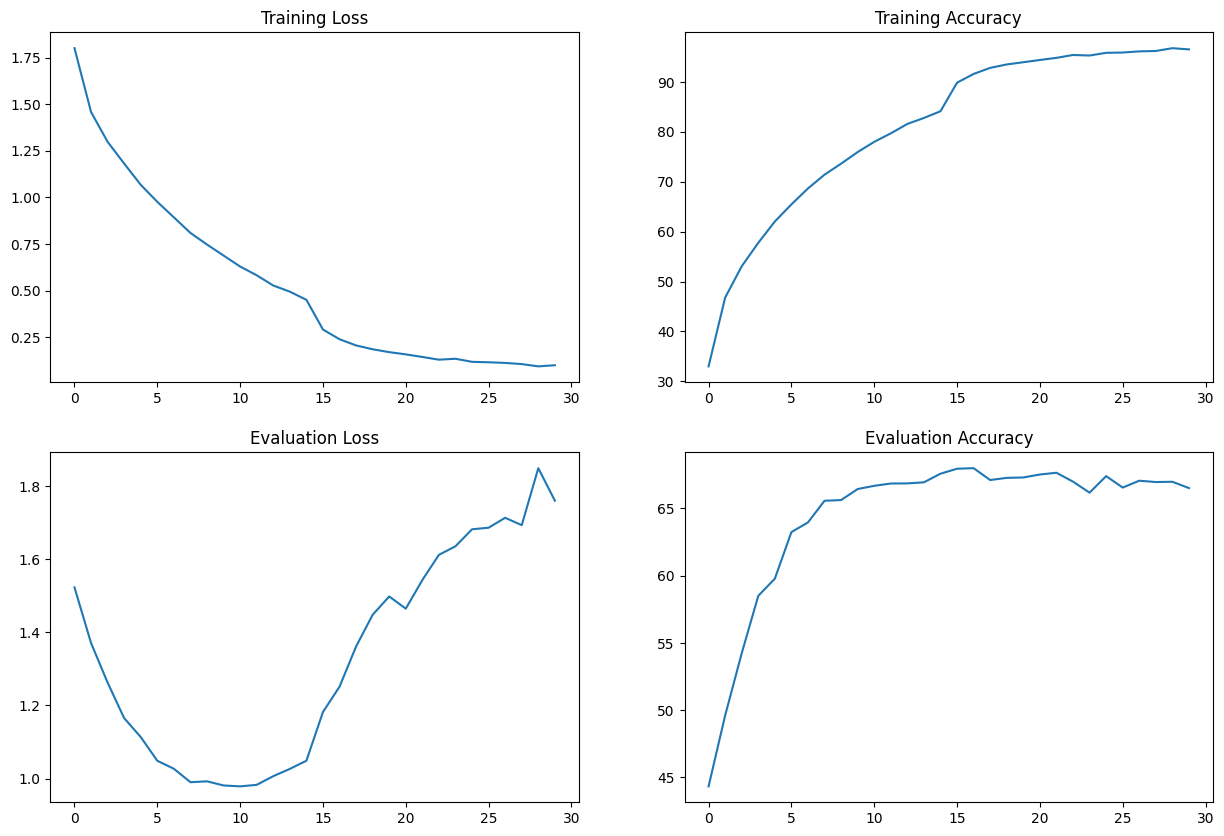

In [ ]:
modelHardswish= CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.Hardswish
)

main(modelHardswish, configA, train_loader, test_loader, "Hardswish_exp")

cuda
Train Epoch: 1	Loss: 1.904022, Accuracy: 28.42%
Eval Epoch: 1	Loss: 1.669272, Accuracy: 37.63%
Train Epoch: 2	Loss: 1.595979, Accuracy: 40.82%
Eval Epoch: 2	Loss: 1.504440, Accuracy: 44.77%
Train Epoch: 3	Loss: 1.446110, Accuracy: 47.35%
Eval Epoch: 3	Loss: 1.396658, Accuracy: 49.21%
Train Epoch: 4	Loss: 1.330848, Accuracy: 52.07%
Eval Epoch: 4	Loss: 1.331940, Accuracy: 52.32%
Train Epoch: 5	Loss: 1.227811, Accuracy: 56.08%
Eval Epoch: 5	Loss: 1.295027, Accuracy: 53.67%
Train Epoch: 6	Loss: 1.146666, Accuracy: 59.45%
Eval Epoch: 6	Loss: 1.207567, Accuracy: 56.74%
Train Epoch: 7	Loss: 1.072861, Accuracy: 62.48%
Eval Epoch: 7	Loss: 1.171976, Accuracy: 59.41%
Train Epoch: 8	Loss: 1.005671, Accuracy: 64.91%
Eval Epoch: 8	Loss: 1.104367, Accuracy: 61.42%
Train Epoch: 9	Loss: 0.943247, Accuracy: 67.11%
Eval Epoch: 9	Loss: 1.121516, Accuracy: 61.16%
Train Epoch: 10	Loss: 0.899444, Accuracy: 68.73%
Eval Epoch: 10	Loss: 1.102496, Accuracy: 61.39%
Train Epoch: 11	Loss: 0.845913, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▇▇▇▇▇▇████████████████▇█
eval_loss,█▆▅▄▄▃▂▁▂▁▁▁▁▁▁▂▂▃▃▄▄▄▅▆▆▇▇▇██
train_accuracy,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,63.56
eval_loss,1.64782
train_accuracy,92.564
train_loss,0.21013


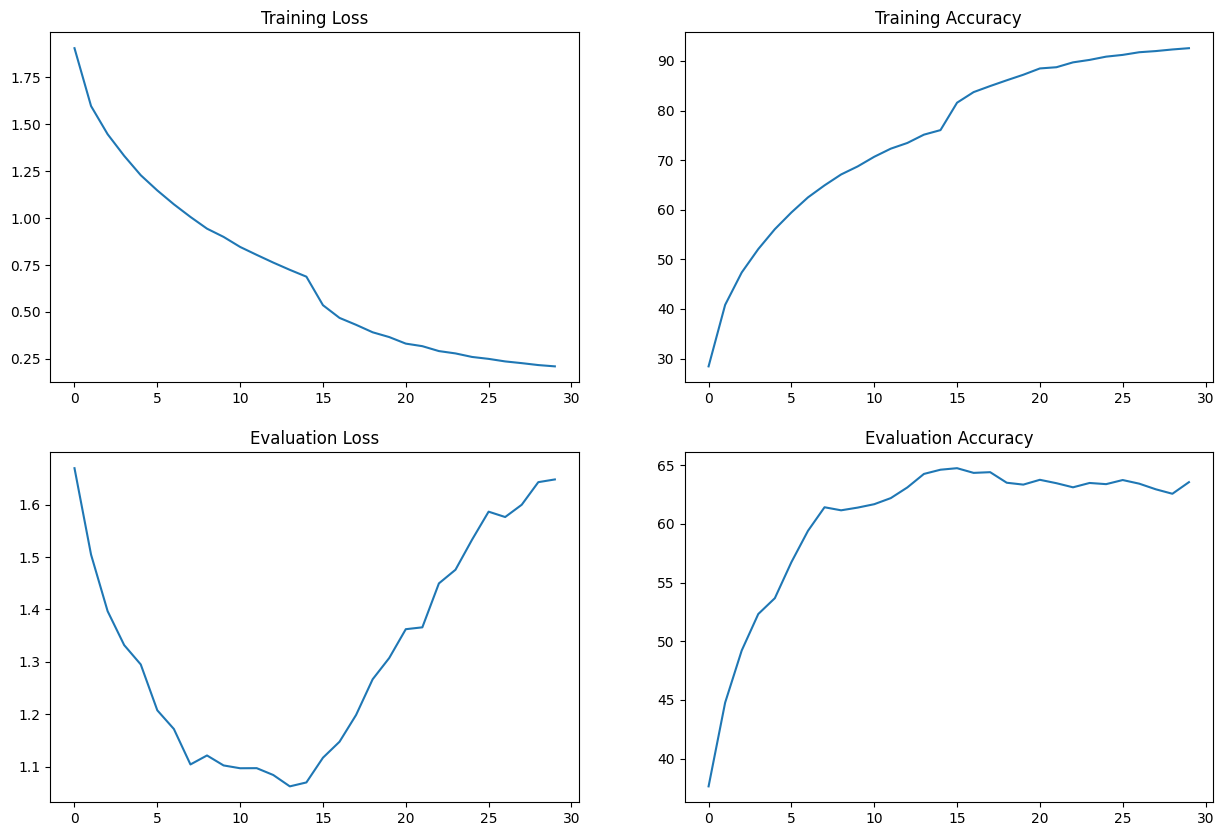

In [ ]:
# Using larger kernel size
modified_kernel_size = [dict(layer, kernel_size=5 if layer.get('groups') == layer.get('in_channels') else layer.get('kernel_size', 3)) for layer in original_architecture]


modelD = CustomMobileNetV2(
    num_classes=configA["num_classes"],
    inverted_block_configs=modified_kernel_size,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)


main(modelD, configA, train_loader, test_loader, "modelD_exp")

Squeeze-and-Excitation

In [ ]:


class SqueezeAndExcitation(nn.Module):
    def __init__(self, input_channels, reduced_dim):
        super(SqueezeAndExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(input_channels, reduced_dim, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_dim, input_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualkWithSE(nn.Module):
    def __init__(self, inp, outp, stride, expand_ratio, se_ratio=0.25, kernel_size=3, activation=nn.ReLU6):
        super().__init__()
        self.stride = stride
        hidden_dim = int(inp * expand_ratio)
        self.use_shortcut = stride == 1 and inp == outp

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNActivation(inp, hidden_dim, kernel_size=1, activation=activation))

        layers.append(ConvBNActivation(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride, groups=hidden_dim, activation=activation))


        if se_ratio > 0:
            layers.append(SqueezeAndExcitation(hidden_dim, int(hidden_dim * se_ratio)))

        self.conv_layers = nn.Sequential(*layers)


        self.project_layer = nn.Sequential(
            nn.Conv2d(hidden_dim, outp, 1, 1, 0, bias=False),
            nn.BatchNorm2d(outp)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = self.project_layer(out)
        if self.use_shortcut:
            return x + out
        else:
            return out


def forward(self, x):
        out = self.conv_layers(x)
        out = self.project_layer(out)
        if self.use_shortcut:
            return x + out
        else:
            return out

class CustomMobileNetV2SE(nn.Module):
    def __init__(self, num_classes, inverted_block_configs, first_layer_channels, expansion_layer_channels, dropout_rate=0.0, activation=nn.ReLU6):
        super(CustomMobileNetV2SE, self).__init__()

        self.first_layer = ConvBNActivation(3, first_layer_channels, kernel_size=3, stride=2, activation=activation)

        self.inverted_blocks = nn.Sequential(
            *[InvertedResidualkWithSE(cfg["inp"], cfg["outp"], cfg["stride"], cfg["expand_ratio"], activation=activation) for cfg in inverted_block_configs]
        )

        self.expansion_layer = ConvBNActivation(inverted_block_configs[-1]['outp'], expansion_layer_channels, kernel_size=1, activation=activation)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(expansion_layer_channels, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.first_layer(x)
        x = self.inverted_blocks(x)
        x = self.expansion_layer(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)




cuda
Train Epoch: 1	Loss: 2.003445, Accuracy: 24.55%
Eval Epoch: 1	Loss: 1.775626, Accuracy: 32.36%
Train Epoch: 2	Loss: 1.654812, Accuracy: 38.84%
Eval Epoch: 2	Loss: 1.561852, Accuracy: 42.36%
Train Epoch: 3	Loss: 1.492048, Accuracy: 45.67%
Eval Epoch: 3	Loss: 1.423930, Accuracy: 48.58%
Train Epoch: 4	Loss: 1.359710, Accuracy: 51.16%
Eval Epoch: 4	Loss: 1.328826, Accuracy: 52.19%
Train Epoch: 5	Loss: 1.257681, Accuracy: 55.04%
Eval Epoch: 5	Loss: 1.276978, Accuracy: 53.65%
Train Epoch: 6	Loss: 1.163545, Accuracy: 58.64%
Eval Epoch: 6	Loss: 1.165830, Accuracy: 58.31%
Train Epoch: 7	Loss: 1.080195, Accuracy: 61.65%
Eval Epoch: 7	Loss: 1.089521, Accuracy: 61.54%
Train Epoch: 8	Loss: 1.003061, Accuracy: 64.82%
Eval Epoch: 8	Loss: 1.066142, Accuracy: 62.90%
Train Epoch: 9	Loss: 0.937324, Accuracy: 67.27%
Eval Epoch: 9	Loss: 1.028927, Accuracy: 63.97%
Train Epoch: 10	Loss: 0.870779, Accuracy: 69.72%
Eval Epoch: 10	Loss: 1.016936, Accuracy: 64.83%
Train Epoch: 11	Loss: 0.820610, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇██████████████████
eval_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████████
train_loss,█▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,30
eval_accuracy,68.84
eval_loss,1.41362
train_accuracy,94.656
train_loss,0.15282


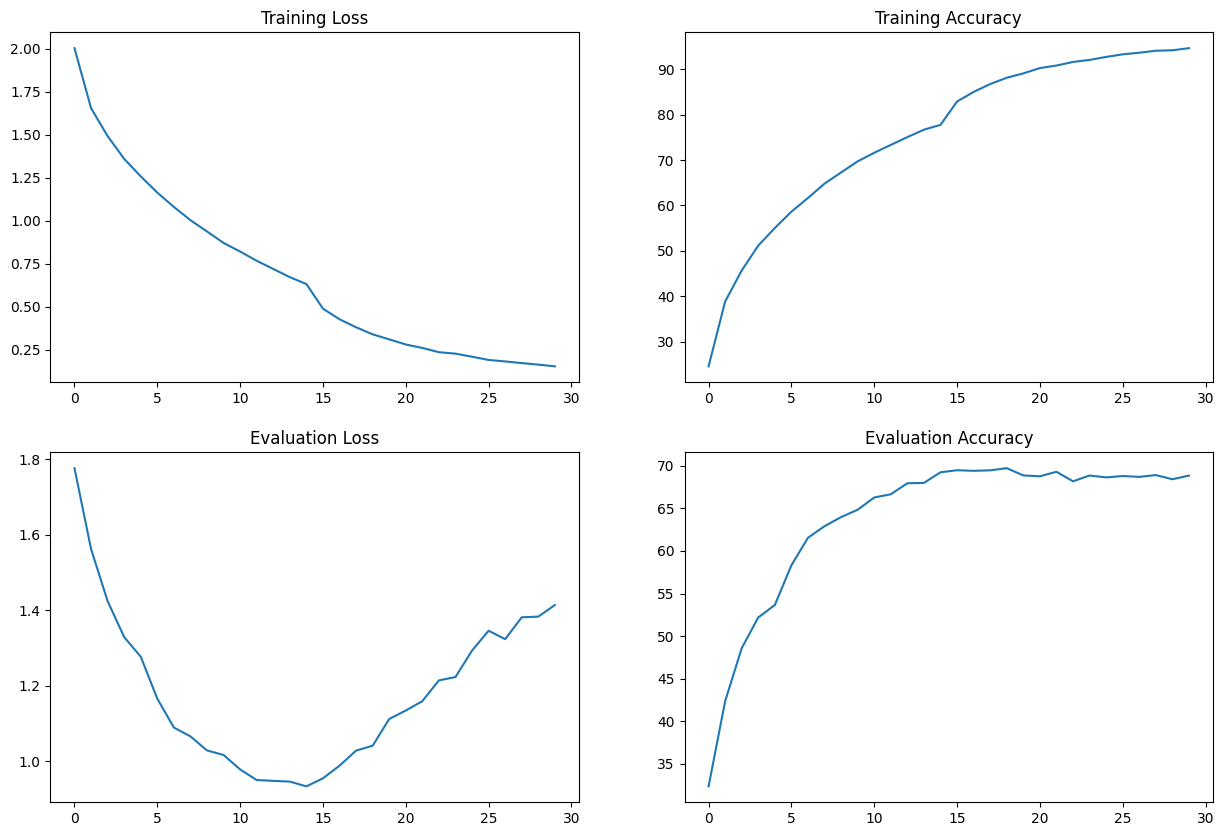

In [ ]:
model_with_SE = CustomMobileNetV2SE(
    num_classes=configA["num_classes"],
    inverted_block_configs=original_architecture,
    first_layer_channels=configA["first_layer_channels"],
    expansion_layer_channels=configA["expansion_layer_channels"],
    dropout_rate=configA.get("dropout_rate", 0.0),
    activation=nn.ReLU6
)


main(model_with_SE, configA, train_loader, test_loader, "model_SE")

## 2

In [ ]:
def main2(model, config, train_loader, test_loader, exp_name):
    with wandb.init(project="arch_2", config=config, name=exp_name) as run:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(device)
        if config["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config.get('weight_decay', 0))

        scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"], gamma= config['scheduler_gamma'])

        train_losses, train_accuracy = [], []
        test_losses, test_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, test_loader, epoch, test_losses, test_accuracy)
            scheduler.step()

        torch.save(model.state_dict(), f'{exp_name}_state_dict.pth')

    plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)

In [ ]:
configA = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 20,
    "optimizer": "Adam",
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "first_layer_channels": 32,
    "expansion_layer_channels": 1280
}

configB = {
    "num_classes": 10,
    "learning_rate": 0.0005,
    "batch_size": 64,
    "epochs": 20,
    "optimizer": "Adam",
    "weight_decay": 1e-4,
    "dropout_rate": 0.3,
    "scheduler_step_size": 15,
    "scheduler_gamma": 0.5,
    "first_layer_channels": 32,
    "expansion_layer_channels": 1280
}

In [ ]:
def create_model(arch, activation_function, block_type, config, train_loader, test_loader):
    if block_type == "Regular":
        model = CustomMobileNetV2(
            num_classes=config["num_classes"],
            inverted_block_configs=arch,
            first_layer_channels=config["first_layer_channels"],
            expansion_layer_channels=config["expansion_layer_channels"],
            dropout_rate=config.get("dropout_rate", 0.0),
            activation=activation_function
        )
    elif block_type == "SE":
        model = CustomMobileNetV2SE(
            num_classes=config["num_classes"],
            inverted_block_configs=arch,
            first_layer_channels=config["first_layer_channels"],
            expansion_layer_channels=config["expansion_layer_channels"],
            dropout_rate=config.get("dropout_rate", 0.0),
            activation=activation_function
        )

    exp_name = f"{activation_function.__name__}_{block_type}_{'configA' if config == configA else 'configB'}"
    main2(model, config, train_loader, test_loader, exp_name)

In [ ]:
arch_expansion10 = [dict(layer, expand_ratio=10 if layer['expand_ratio'] == 6 else layer['expand_ratio']) for layer in original_architecture]

cuda
Train Epoch: 1	Loss: 1.831969, Accuracy: 32.06%
Eval Epoch: 1	Loss: 1.569135, Accuracy: 43.42%
Train Epoch: 2	Loss: 1.478153, Accuracy: 45.94%
Eval Epoch: 2	Loss: 1.378669, Accuracy: 50.50%
Train Epoch: 3	Loss: 1.317106, Accuracy: 52.63%
Eval Epoch: 3	Loss: 1.283631, Accuracy: 54.29%
Train Epoch: 4	Loss: 1.193659, Accuracy: 57.54%
Eval Epoch: 4	Loss: 1.183982, Accuracy: 58.09%
Train Epoch: 5	Loss: 1.084320, Accuracy: 61.80%
Eval Epoch: 5	Loss: 1.095142, Accuracy: 61.36%
Train Epoch: 6	Loss: 0.991877, Accuracy: 65.27%
Eval Epoch: 6	Loss: 1.066789, Accuracy: 62.31%
Train Epoch: 7	Loss: 0.912328, Accuracy: 68.39%
Eval Epoch: 7	Loss: 1.037802, Accuracy: 63.79%
Train Epoch: 8	Loss: 0.842053, Accuracy: 70.93%
Eval Epoch: 8	Loss: 1.011608, Accuracy: 64.72%
Train Epoch: 9	Loss: 0.779526, Accuracy: 72.99%
Eval Epoch: 9	Loss: 1.042532, Accuracy: 64.43%
Train Epoch: 10	Loss: 0.715063, Accuracy: 75.26%
Eval Epoch: 10	Loss: 0.973694, Accuracy: 67.81%
Train Epoch: 11	Loss: 0.657340, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▇▇▇█▇█▇███████
eval_loss,█▆▅▃▂▂▂▁▂▁▂▁▂▂▂▂▃▅▅▆
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇████
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,67.24
eval_loss,1.38953
train_accuracy,93.88
train_loss,0.18041


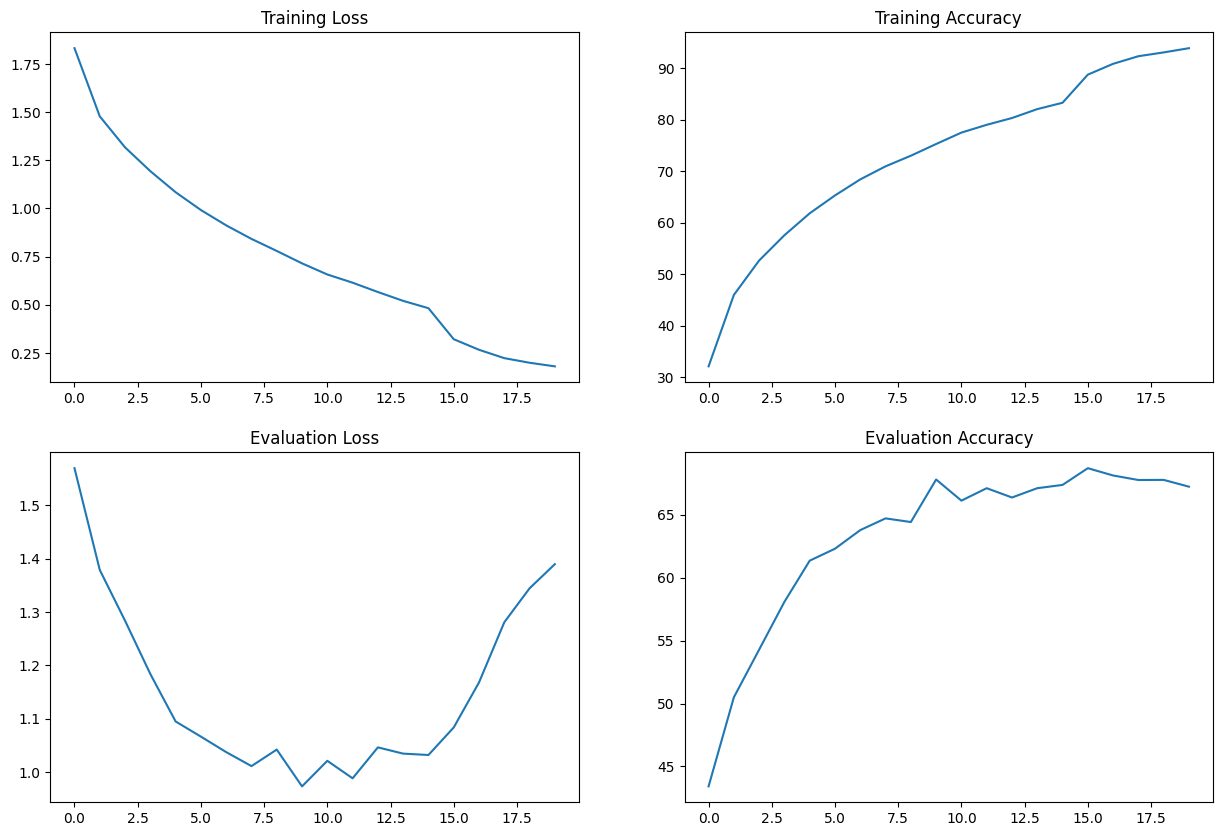

cuda
Train Epoch: 1	Loss: 1.864258, Accuracy: 30.33%
Eval Epoch: 1	Loss: 1.569170, Accuracy: 42.85%
Train Epoch: 2	Loss: 1.496074, Accuracy: 45.61%
Eval Epoch: 2	Loss: 1.384178, Accuracy: 50.11%
Train Epoch: 3	Loss: 1.320290, Accuracy: 52.76%
Eval Epoch: 3	Loss: 1.270857, Accuracy: 54.26%
Train Epoch: 4	Loss: 1.190746, Accuracy: 57.73%
Eval Epoch: 4	Loss: 1.202545, Accuracy: 57.63%
Train Epoch: 5	Loss: 1.071725, Accuracy: 62.39%
Eval Epoch: 5	Loss: 1.089956, Accuracy: 61.69%
Train Epoch: 6	Loss: 0.974261, Accuracy: 66.23%
Eval Epoch: 6	Loss: 1.089556, Accuracy: 62.59%
Train Epoch: 7	Loss: 0.891435, Accuracy: 69.04%
Eval Epoch: 7	Loss: 1.050482, Accuracy: 63.48%
Train Epoch: 8	Loss: 0.818440, Accuracy: 71.77%
Eval Epoch: 8	Loss: 0.996682, Accuracy: 65.54%
Train Epoch: 9	Loss: 0.749992, Accuracy: 74.45%
Eval Epoch: 9	Loss: 0.944852, Accuracy: 67.42%
Train Epoch: 10	Loss: 0.696815, Accuracy: 75.96%
Eval Epoch: 10	Loss: 0.942255, Accuracy: 68.19%
Train Epoch: 11	Loss: 0.643907, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇█▇██████
eval_loss,█▆▅▄▃▃▂▂▁▁▁▁▁▂▁▂▃▄▄▅
train_accuracy,▁▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,69.58
eval_loss,1.26012
train_accuracy,93.89
train_loss,0.18335


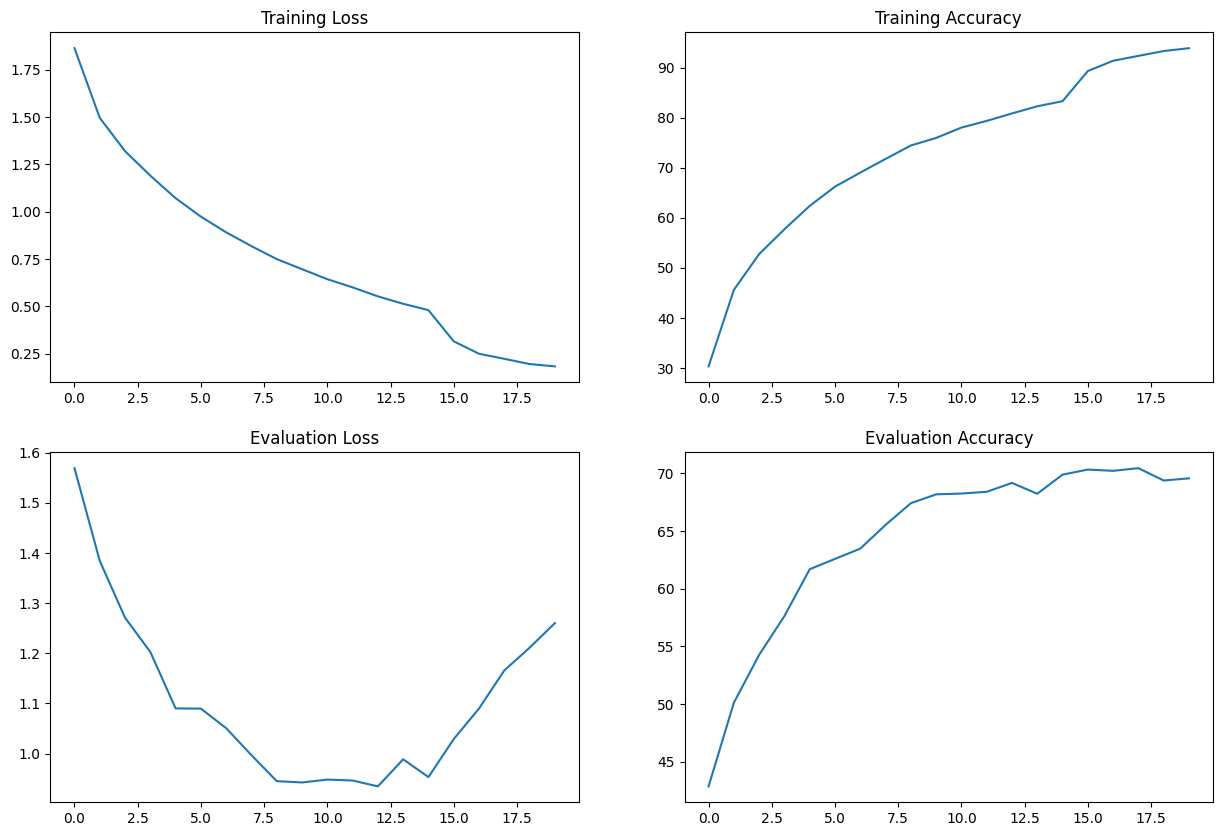

cuda
Train Epoch: 1	Loss: 1.910479, Accuracy: 27.94%
Eval Epoch: 1	Loss: 1.623681, Accuracy: 40.43%
Train Epoch: 2	Loss: 1.527693, Accuracy: 44.58%
Eval Epoch: 2	Loss: 1.411337, Accuracy: 48.92%
Train Epoch: 3	Loss: 1.345280, Accuracy: 51.66%
Eval Epoch: 3	Loss: 1.323548, Accuracy: 53.39%
Train Epoch: 4	Loss: 1.209602, Accuracy: 57.21%
Eval Epoch: 4	Loss: 1.171448, Accuracy: 58.35%
Train Epoch: 5	Loss: 1.101220, Accuracy: 60.99%
Eval Epoch: 5	Loss: 1.117596, Accuracy: 60.32%
Train Epoch: 6	Loss: 1.007053, Accuracy: 64.42%
Eval Epoch: 6	Loss: 1.062646, Accuracy: 62.74%
Train Epoch: 7	Loss: 0.928891, Accuracy: 67.43%
Eval Epoch: 7	Loss: 1.015657, Accuracy: 64.76%
Train Epoch: 8	Loss: 0.849379, Accuracy: 70.24%
Eval Epoch: 8	Loss: 0.956101, Accuracy: 67.06%
Train Epoch: 9	Loss: 0.778827, Accuracy: 72.70%
Eval Epoch: 9	Loss: 0.922276, Accuracy: 68.00%
Train Epoch: 10	Loss: 0.721772, Accuracy: 74.95%
Eval Epoch: 10	Loss: 0.895443, Accuracy: 69.40%
Train Epoch: 11	Loss: 0.666718, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████
eval_loss,█▆▅▄▃▃▂▂▁▁▁▁▁▁▁▂▂▃▄▄
train_accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,71.35
eval_loss,1.20021
train_accuracy,94.142
train_loss,0.16637


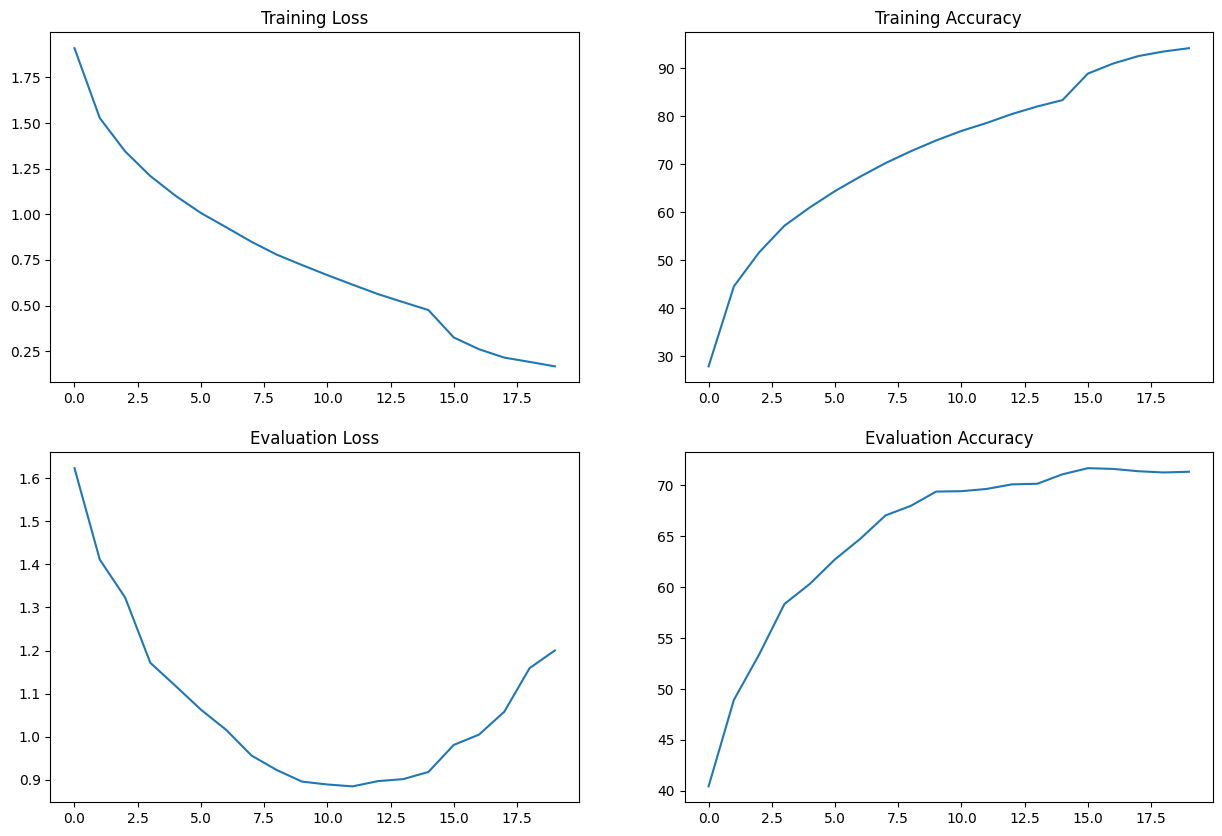

cuda
Train Epoch: 1	Loss: 1.905808, Accuracy: 28.47%
Eval Epoch: 1	Loss: 1.609826, Accuracy: 39.50%
Train Epoch: 2	Loss: 1.525794, Accuracy: 44.04%
Eval Epoch: 2	Loss: 1.403271, Accuracy: 49.47%
Train Epoch: 3	Loss: 1.349677, Accuracy: 51.70%
Eval Epoch: 3	Loss: 1.315794, Accuracy: 52.46%
Train Epoch: 4	Loss: 1.203891, Accuracy: 57.29%
Eval Epoch: 4	Loss: 1.167962, Accuracy: 57.35%
Train Epoch: 5	Loss: 1.089785, Accuracy: 61.77%
Eval Epoch: 5	Loss: 1.090553, Accuracy: 61.79%
Train Epoch: 6	Loss: 0.997737, Accuracy: 65.02%
Eval Epoch: 6	Loss: 1.021023, Accuracy: 63.78%
Train Epoch: 7	Loss: 0.925210, Accuracy: 67.91%
Eval Epoch: 7	Loss: 0.983082, Accuracy: 65.31%
Train Epoch: 8	Loss: 0.858210, Accuracy: 70.28%
Eval Epoch: 8	Loss: 0.984524, Accuracy: 65.46%
Train Epoch: 9	Loss: 0.794898, Accuracy: 72.43%
Eval Epoch: 9	Loss: 0.943745, Accuracy: 67.53%
Train Epoch: 10	Loss: 0.747242, Accuracy: 73.95%
Eval Epoch: 10	Loss: 0.898591, Accuracy: 68.97%
Train Epoch: 11	Loss: 0.688640, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▇▇▇▇▇█▇█▇█████
eval_loss,█▆▅▄▃▂▂▂▂▁▁▁▂▁▁▁▂▂▃▃
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,71.24
eval_loss,1.08732
train_accuracy,92.676
train_loss,0.21168


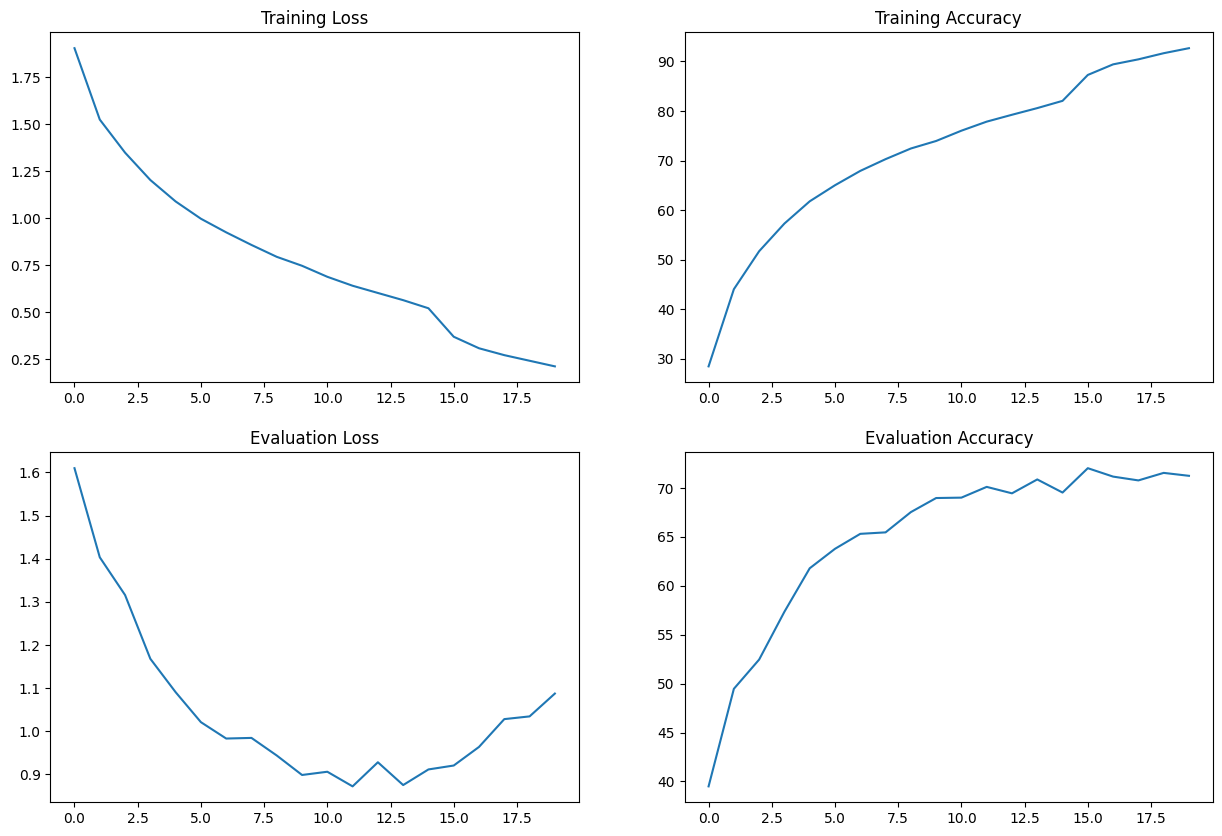

cuda
Train Epoch: 1	Loss: 1.660712, Accuracy: 38.73%
Eval Epoch: 1	Loss: 1.404476, Accuracy: 48.06%
Train Epoch: 2	Loss: 1.280125, Accuracy: 53.99%
Eval Epoch: 2	Loss: 1.144179, Accuracy: 59.15%
Train Epoch: 3	Loss: 1.083252, Accuracy: 61.76%
Eval Epoch: 3	Loss: 1.056744, Accuracy: 62.68%
Train Epoch: 4	Loss: 0.940461, Accuracy: 67.09%
Eval Epoch: 4	Loss: 0.972729, Accuracy: 66.12%
Train Epoch: 5	Loss: 0.822483, Accuracy: 71.66%
Eval Epoch: 5	Loss: 0.910901, Accuracy: 68.22%
Train Epoch: 6	Loss: 0.736588, Accuracy: 74.70%
Eval Epoch: 6	Loss: 0.896030, Accuracy: 69.66%
Train Epoch: 7	Loss: 0.657781, Accuracy: 77.31%
Eval Epoch: 7	Loss: 0.893654, Accuracy: 69.74%
Train Epoch: 8	Loss: 0.582800, Accuracy: 79.96%
Eval Epoch: 8	Loss: 0.911762, Accuracy: 69.92%
Train Epoch: 9	Loss: 0.527821, Accuracy: 81.92%
Eval Epoch: 9	Loss: 0.885530, Accuracy: 70.23%
Train Epoch: 10	Loss: 0.468843, Accuracy: 83.90%
Eval Epoch: 10	Loss: 0.906998, Accuracy: 70.31%
Train Epoch: 11	Loss: 0.419118, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▄▅▆▇▇▇█████████████
eval_loss,▇▄▃▂▁▁▁▁▁▁▂▂▃▃▃▅▆▇██
train_accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,71.48
eval_loss,1.49574
train_accuracy,97.236
train_loss,0.07998


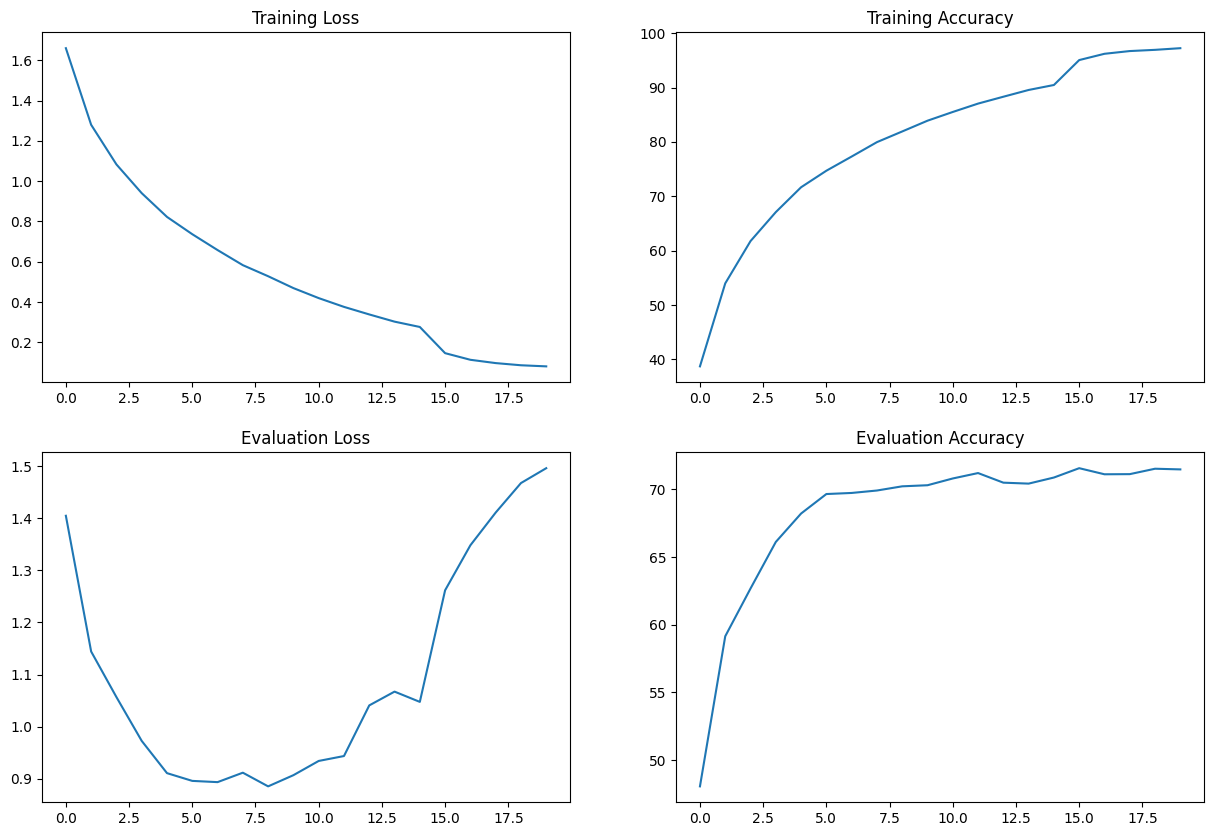

cuda
Train Epoch: 1	Loss: 1.698745, Accuracy: 37.21%
Eval Epoch: 1	Loss: 1.407630, Accuracy: 48.85%
Train Epoch: 2	Loss: 1.295336, Accuracy: 53.44%
Eval Epoch: 2	Loss: 1.188803, Accuracy: 57.79%
Train Epoch: 3	Loss: 1.111340, Accuracy: 60.47%
Eval Epoch: 3	Loss: 1.103253, Accuracy: 61.09%
Train Epoch: 4	Loss: 0.979620, Accuracy: 65.41%
Eval Epoch: 4	Loss: 1.042221, Accuracy: 63.53%
Train Epoch: 5	Loss: 0.868624, Accuracy: 69.81%
Eval Epoch: 5	Loss: 0.960225, Accuracy: 66.94%
Train Epoch: 6	Loss: 0.787139, Accuracy: 72.62%
Eval Epoch: 6	Loss: 0.923573, Accuracy: 68.24%
Train Epoch: 7	Loss: 0.718235, Accuracy: 75.13%
Eval Epoch: 7	Loss: 0.897346, Accuracy: 69.22%
Train Epoch: 8	Loss: 0.647100, Accuracy: 77.65%
Eval Epoch: 8	Loss: 0.922288, Accuracy: 69.35%
Train Epoch: 9	Loss: 0.592618, Accuracy: 79.54%
Eval Epoch: 9	Loss: 0.912149, Accuracy: 69.94%
Train Epoch: 10	Loss: 0.533325, Accuracy: 81.36%
Eval Epoch: 10	Loss: 0.897325, Accuracy: 71.36%
Train Epoch: 11	Loss: 0.495358, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▄▅▆▇▇▇▇▇██▇████████
eval_loss,█▅▄▃▂▁▁▁▁▁▁▂▂▁▂▃▆▆▆▇
train_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇█████
train_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,71.17
eval_loss,1.3186
train_accuracy,95.442
train_loss,0.13399


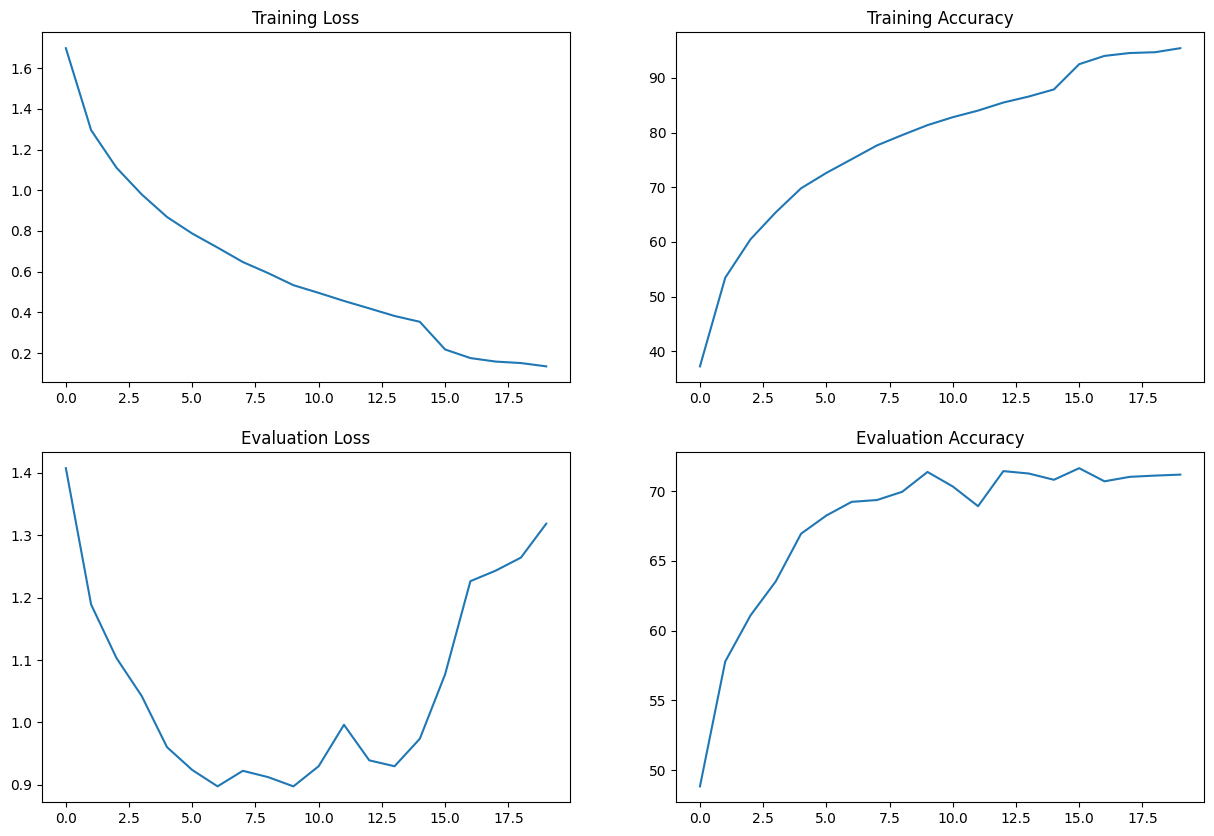

cuda
Train Epoch: 1	Loss: 1.781017, Accuracy: 33.43%
Eval Epoch: 1	Loss: 1.512563, Accuracy: 44.40%
Train Epoch: 2	Loss: 1.402426, Accuracy: 49.27%
Eval Epoch: 2	Loss: 1.332308, Accuracy: 52.64%
Train Epoch: 3	Loss: 1.210620, Accuracy: 56.84%
Eval Epoch: 3	Loss: 1.139922, Accuracy: 59.84%
Train Epoch: 4	Loss: 1.051830, Accuracy: 63.22%
Eval Epoch: 4	Loss: 1.084607, Accuracy: 61.77%
Train Epoch: 5	Loss: 0.930197, Accuracy: 67.66%
Eval Epoch: 5	Loss: 0.978471, Accuracy: 65.19%
Train Epoch: 6	Loss: 0.827315, Accuracy: 71.14%
Eval Epoch: 6	Loss: 0.957029, Accuracy: 65.85%
Train Epoch: 7	Loss: 0.737392, Accuracy: 74.34%
Eval Epoch: 7	Loss: 0.897778, Accuracy: 68.59%
Train Epoch: 8	Loss: 0.654667, Accuracy: 77.25%
Eval Epoch: 8	Loss: 0.898840, Accuracy: 69.18%
Train Epoch: 9	Loss: 0.582468, Accuracy: 79.86%
Eval Epoch: 9	Loss: 0.883021, Accuracy: 70.27%
Train Epoch: 10	Loss: 0.511617, Accuracy: 82.16%
Eval Epoch: 10	Loss: 0.901830, Accuracy: 69.65%
Train Epoch: 11	Loss: 0.462879, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▅▅▆▆▇▇█▇██████████
eval_loss,█▆▄▃▂▂▁▁▁▁▁▂▂▂▃▅▆▇▆▇
train_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,71.89
eval_loss,1.39521
train_accuracy,97.496
train_loss,0.07192


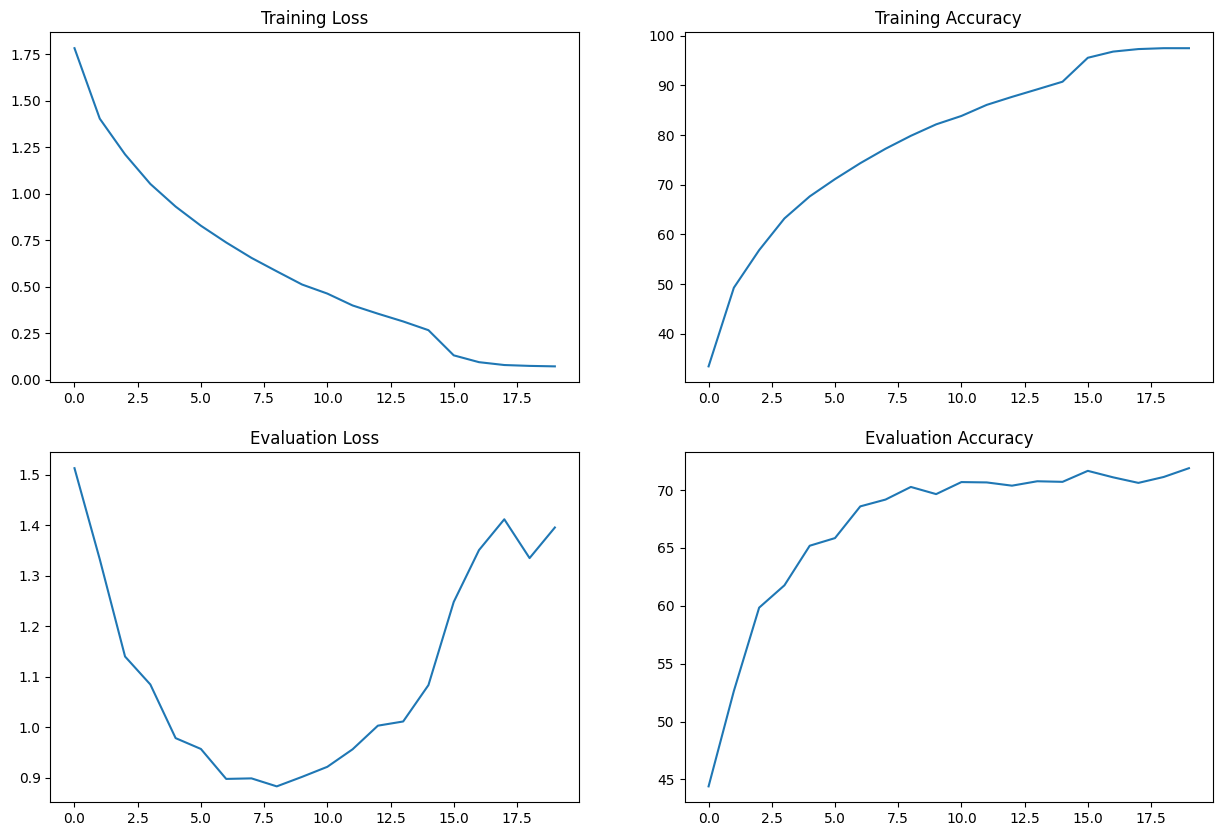

cuda
Train Epoch: 1	Loss: 1.811481, Accuracy: 32.37%
Eval Epoch: 1	Loss: 1.527792, Accuracy: 43.67%
Train Epoch: 2	Loss: 1.422867, Accuracy: 48.32%
Eval Epoch: 2	Loss: 1.314788, Accuracy: 52.98%
Train Epoch: 3	Loss: 1.222998, Accuracy: 55.99%
Eval Epoch: 3	Loss: 1.150874, Accuracy: 59.14%
Train Epoch: 4	Loss: 1.072653, Accuracy: 61.90%
Eval Epoch: 4	Loss: 1.060422, Accuracy: 62.77%
Train Epoch: 5	Loss: 0.951810, Accuracy: 66.45%
Eval Epoch: 5	Loss: 0.965709, Accuracy: 65.32%
Train Epoch: 6	Loss: 0.852250, Accuracy: 70.17%
Eval Epoch: 6	Loss: 0.929376, Accuracy: 67.45%
Train Epoch: 7	Loss: 0.767062, Accuracy: 73.28%
Eval Epoch: 7	Loss: 0.881102, Accuracy: 69.48%
Train Epoch: 8	Loss: 0.726985, Accuracy: 74.55%
Eval Epoch: 8	Loss: 0.858218, Accuracy: 70.58%
Train Epoch: 9	Loss: 0.636770, Accuracy: 77.78%
Eval Epoch: 9	Loss: 0.828664, Accuracy: 71.54%
Train Epoch: 10	Loss: 0.577628, Accuracy: 80.07%
Eval Epoch: 10	Loss: 0.834328, Accuracy: 70.91%
Train Epoch: 11	Loss: 0.525800, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▅▆▆▇▇▇█▇██████████
eval_loss,█▆▄▃▂▂▂▁▁▁▃▁▃▂▂▃▄▆▅▆
train_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇█████
train_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,71.61
eval_loss,1.35552
train_accuracy,95.592
train_loss,0.12728


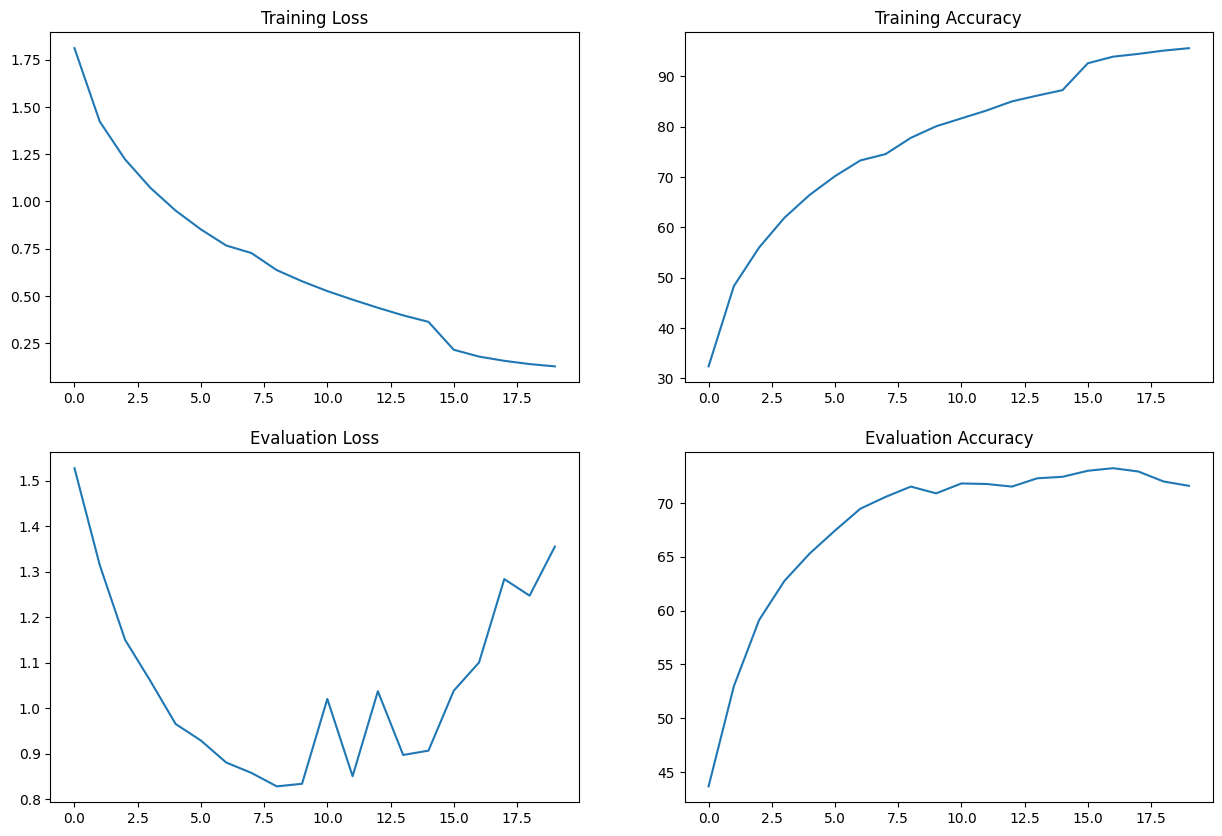

cuda
Train Epoch: 1	Loss: 1.826278, Accuracy: 32.18%
Eval Epoch: 1	Loss: 1.543033, Accuracy: 42.64%
Train Epoch: 2	Loss: 1.467113, Accuracy: 47.23%
Eval Epoch: 2	Loss: 1.371307, Accuracy: 50.44%
Train Epoch: 3	Loss: 1.291982, Accuracy: 53.90%
Eval Epoch: 3	Loss: 1.284916, Accuracy: 53.80%
Train Epoch: 4	Loss: 1.161442, Accuracy: 58.89%
Eval Epoch: 4	Loss: 1.137187, Accuracy: 59.60%
Train Epoch: 5	Loss: 1.049001, Accuracy: 63.22%
Eval Epoch: 5	Loss: 1.112587, Accuracy: 60.92%
Train Epoch: 6	Loss: 0.959559, Accuracy: 66.61%
Eval Epoch: 6	Loss: 1.048572, Accuracy: 63.45%
Train Epoch: 7	Loss: 0.879572, Accuracy: 69.73%
Eval Epoch: 7	Loss: 0.999789, Accuracy: 64.90%
Train Epoch: 8	Loss: 0.812023, Accuracy: 72.11%
Eval Epoch: 8	Loss: 0.990707, Accuracy: 65.84%
Train Epoch: 9	Loss: 0.736686, Accuracy: 74.66%
Eval Epoch: 9	Loss: 1.073719, Accuracy: 62.47%
Train Epoch: 10	Loss: 0.686738, Accuracy: 76.32%
Eval Epoch: 10	Loss: 0.994035, Accuracy: 66.79%
Train Epoch: 11	Loss: 0.624939, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▇▇▆▇██████████
eval_loss,█▆▅▃▃▂▂▂▃▂▁▁▂▂▂▃▄▅▆▆
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,68.92
eval_loss,1.36056
train_accuracy,94.564
train_loss,0.15861


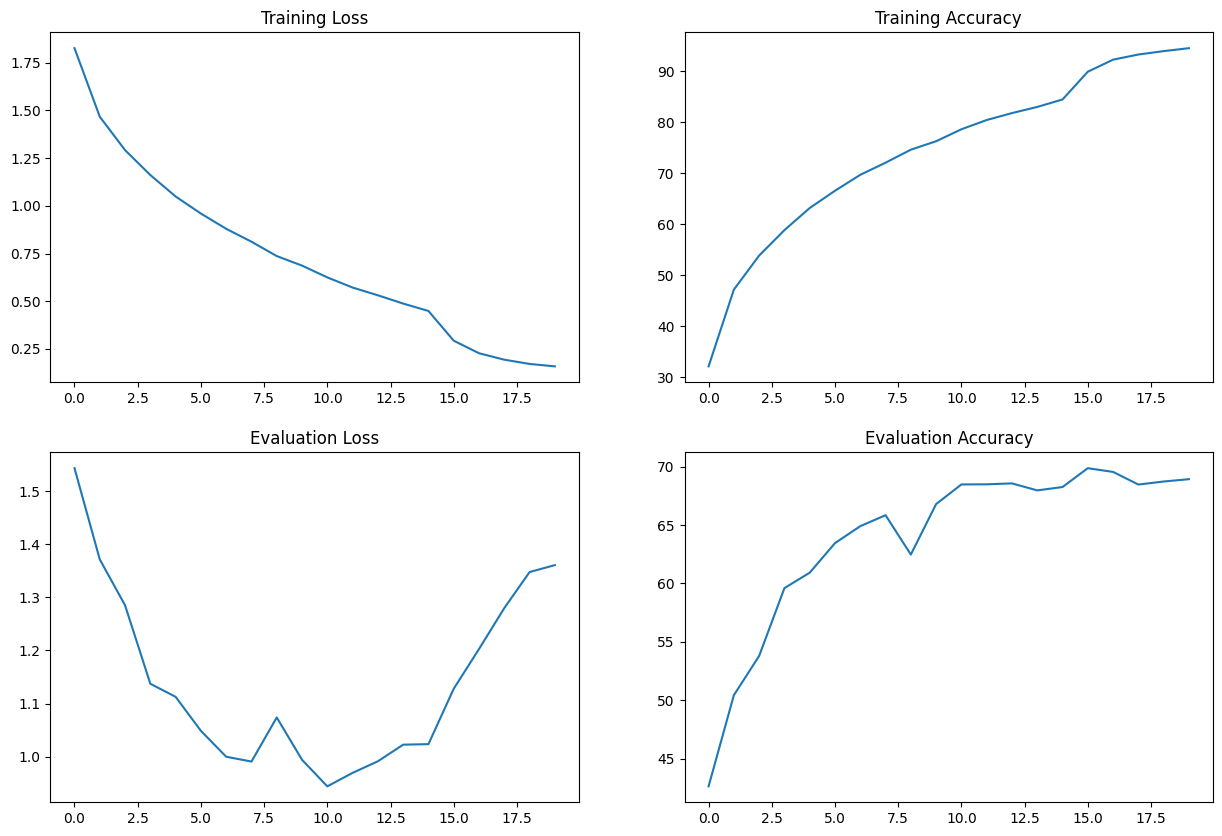

cuda
Train Epoch: 1	Loss: 1.824385, Accuracy: 32.46%
Eval Epoch: 1	Loss: 1.571643, Accuracy: 42.45%
Train Epoch: 2	Loss: 1.476353, Accuracy: 46.64%
Eval Epoch: 2	Loss: 1.375925, Accuracy: 50.69%
Train Epoch: 3	Loss: 1.309742, Accuracy: 53.21%
Eval Epoch: 3	Loss: 1.271624, Accuracy: 55.28%
Train Epoch: 4	Loss: 1.177485, Accuracy: 58.47%
Eval Epoch: 4	Loss: 1.176643, Accuracy: 58.37%
Train Epoch: 5	Loss: 1.058070, Accuracy: 62.85%
Eval Epoch: 5	Loss: 1.140688, Accuracy: 59.91%
Train Epoch: 6	Loss: 0.966374, Accuracy: 66.29%
Eval Epoch: 6	Loss: 1.048111, Accuracy: 62.94%
Train Epoch: 7	Loss: 0.880280, Accuracy: 69.44%
Eval Epoch: 7	Loss: 1.005514, Accuracy: 65.10%
Train Epoch: 8	Loss: 0.811849, Accuracy: 72.04%
Eval Epoch: 8	Loss: 0.979429, Accuracy: 66.01%
Train Epoch: 9	Loss: 0.743386, Accuracy: 74.65%
Eval Epoch: 9	Loss: 1.007733, Accuracy: 65.84%
Train Epoch: 10	Loss: 0.689512, Accuracy: 76.31%
Eval Epoch: 10	Loss: 0.931826, Accuracy: 68.37%
Train Epoch: 11	Loss: 0.634161, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▇▇▇███▇███████
eval_loss,█▆▅▄▃▂▂▂▂▁▁▁▂▁▁▂▃▄▄▅
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,69.21
eval_loss,1.28408
train_accuracy,94.134
train_loss,0.17133


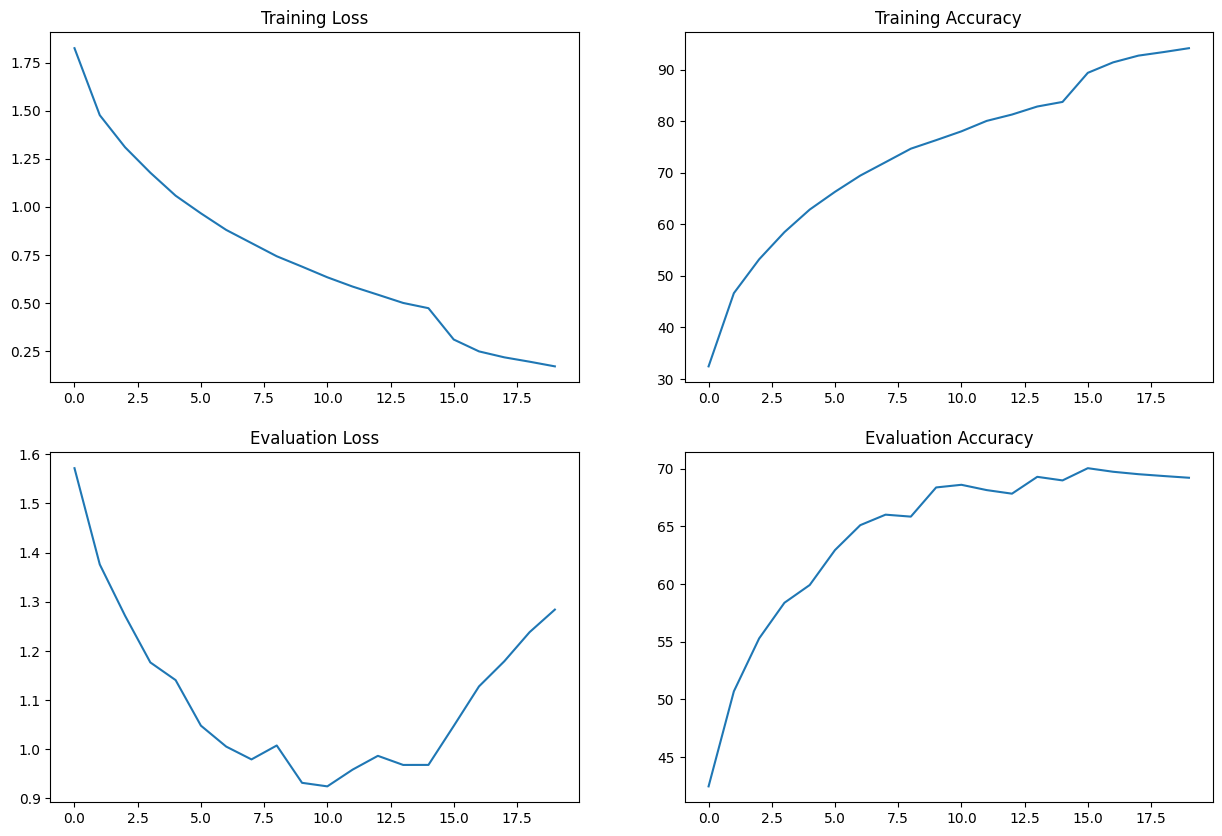

cuda
Train Epoch: 1	Loss: 1.859965, Accuracy: 30.44%
Eval Epoch: 1	Loss: 1.613029, Accuracy: 39.50%
Train Epoch: 2	Loss: 1.491725, Accuracy: 45.98%
Eval Epoch: 2	Loss: 1.391622, Accuracy: 48.39%
Train Epoch: 3	Loss: 1.321977, Accuracy: 52.73%
Eval Epoch: 3	Loss: 1.269141, Accuracy: 54.18%
Train Epoch: 4	Loss: 1.196682, Accuracy: 57.53%
Eval Epoch: 4	Loss: 1.166968, Accuracy: 58.60%
Train Epoch: 5	Loss: 1.094285, Accuracy: 61.43%
Eval Epoch: 5	Loss: 1.106896, Accuracy: 59.88%
Train Epoch: 6	Loss: 1.003051, Accuracy: 64.93%
Eval Epoch: 6	Loss: 1.036155, Accuracy: 63.24%
Train Epoch: 7	Loss: 0.916918, Accuracy: 68.04%
Eval Epoch: 7	Loss: 0.989432, Accuracy: 65.26%
Train Epoch: 8	Loss: 0.850149, Accuracy: 70.51%
Eval Epoch: 8	Loss: 0.978006, Accuracy: 66.49%
Train Epoch: 9	Loss: 0.781255, Accuracy: 72.99%
Eval Epoch: 9	Loss: 0.907007, Accuracy: 68.83%
Train Epoch: 10	Loss: 0.723091, Accuracy: 75.16%
Eval Epoch: 10	Loss: 0.926760, Accuracy: 67.87%
Train Epoch: 11	Loss: 0.668694, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▇▇▇▇▇█████████
eval_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▂▂▂▃▃▄
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇████
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,71.22
eval_loss,1.16936
train_accuracy,93.676
train_loss,0.18074


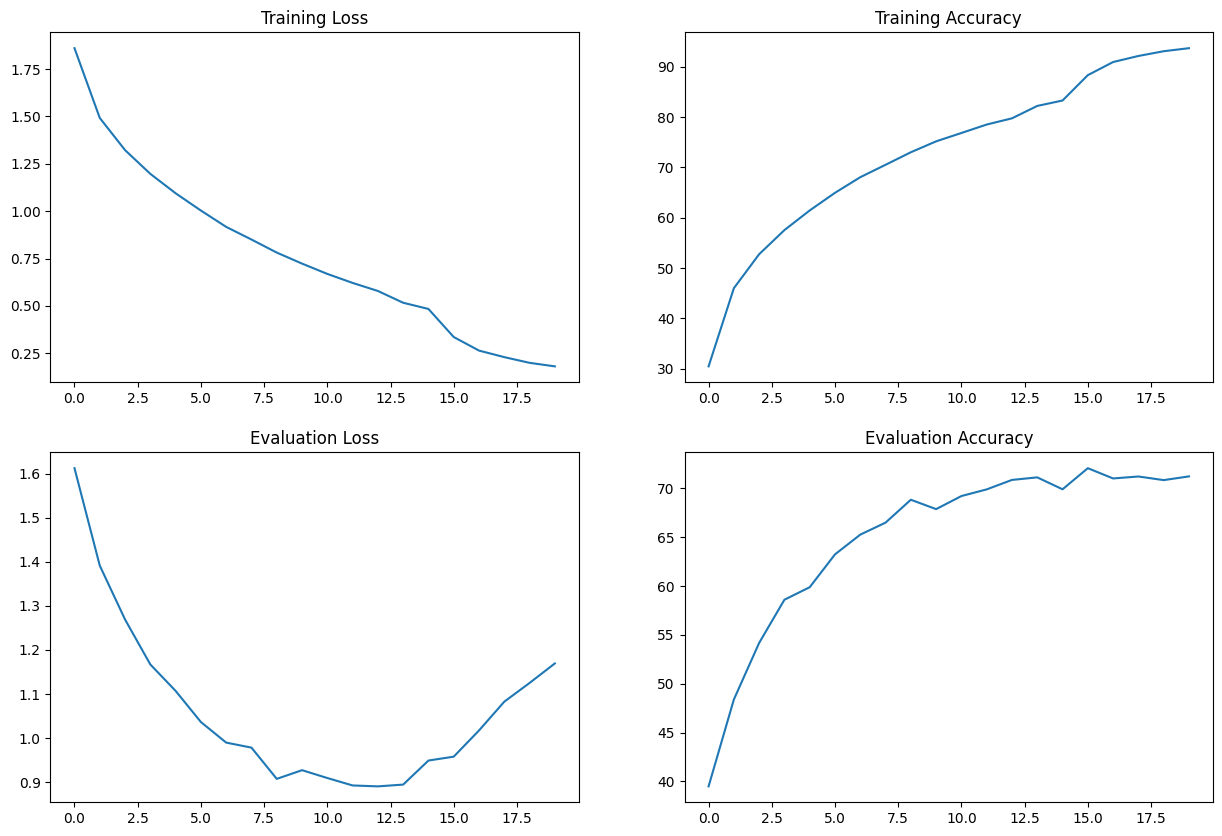

cuda
Train Epoch: 1	Loss: 1.855587, Accuracy: 30.23%
Eval Epoch: 1	Loss: 1.585374, Accuracy: 41.03%
Train Epoch: 2	Loss: 1.512806, Accuracy: 44.44%
Eval Epoch: 2	Loss: 1.426519, Accuracy: 48.04%
Train Epoch: 3	Loss: 1.345251, Accuracy: 51.76%
Eval Epoch: 3	Loss: 1.301359, Accuracy: 52.64%
Train Epoch: 4	Loss: 1.208151, Accuracy: 57.17%
Eval Epoch: 4	Loss: 1.168345, Accuracy: 58.45%
Train Epoch: 5	Loss: 1.086976, Accuracy: 61.88%
Eval Epoch: 5	Loss: 1.104359, Accuracy: 60.70%
Train Epoch: 6	Loss: 0.993275, Accuracy: 65.33%
Eval Epoch: 6	Loss: 1.021261, Accuracy: 64.48%
Train Epoch: 7	Loss: 0.915009, Accuracy: 68.15%
Eval Epoch: 7	Loss: 1.076747, Accuracy: 62.22%
Train Epoch: 8	Loss: 0.845010, Accuracy: 70.83%
Eval Epoch: 8	Loss: 0.962103, Accuracy: 67.10%
Train Epoch: 9	Loss: 0.783548, Accuracy: 72.95%
Eval Epoch: 9	Loss: 0.914681, Accuracy: 68.99%
Train Epoch: 10	Loss: 0.718428, Accuracy: 75.50%
Eval Epoch: 10	Loss: 0.900246, Accuracy: 69.40%
Train Epoch: 11	Loss: 0.666163, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▆▇▇▇▇█████████
eval_loss,█▆▅▄▃▂▃▂▁▁▁▁▁▁▁▂▂▃▃▄
train_accuracy,▁▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁
epoch,20
eval_accuracy,70.93
eval_loss,1.13538
train_accuracy,93.176
train_loss,0.19925


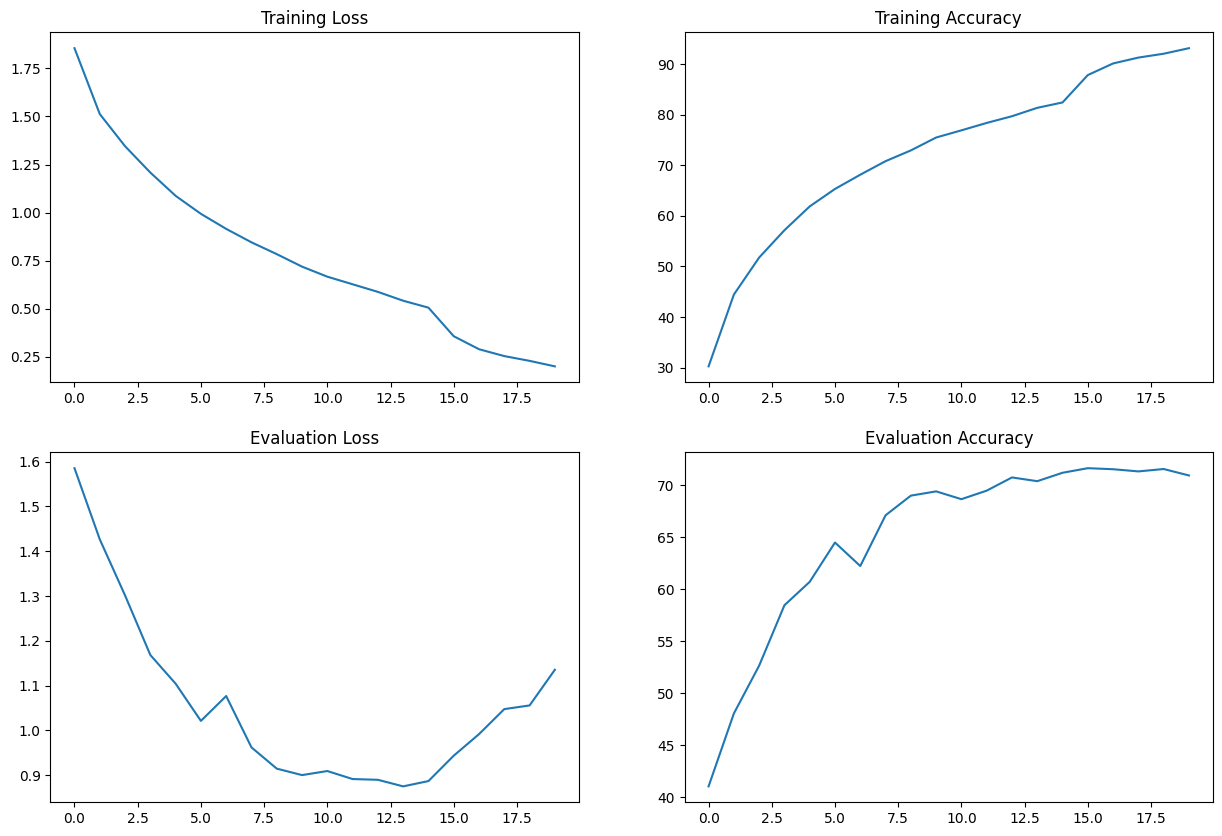

cuda
Train Epoch: 1	Loss: 1.789987, Accuracy: 33.24%
Eval Epoch: 1	Loss: 1.496016, Accuracy: 45.86%
Train Epoch: 2	Loss: 1.406091, Accuracy: 48.91%
Eval Epoch: 2	Loss: 1.286737, Accuracy: 53.44%
Train Epoch: 3	Loss: 1.196937, Accuracy: 57.17%
Eval Epoch: 3	Loss: 1.147284, Accuracy: 59.63%
Train Epoch: 4	Loss: 1.046960, Accuracy: 62.87%
Eval Epoch: 4	Loss: 1.038670, Accuracy: 63.50%
Train Epoch: 5	Loss: 0.921006, Accuracy: 67.77%
Eval Epoch: 5	Loss: 0.979299, Accuracy: 65.67%
Train Epoch: 6	Loss: 0.820348, Accuracy: 71.38%
Eval Epoch: 6	Loss: 0.947864, Accuracy: 67.21%
Train Epoch: 7	Loss: 0.739685, Accuracy: 74.17%
Eval Epoch: 7	Loss: 0.910010, Accuracy: 68.33%
Train Epoch: 8	Loss: 0.669649, Accuracy: 76.56%
Eval Epoch: 8	Loss: 0.922537, Accuracy: 68.14%
Train Epoch: 9	Loss: 0.615169, Accuracy: 78.63%
Eval Epoch: 9	Loss: 0.889455, Accuracy: 69.83%
Train Epoch: 10	Loss: 0.539018, Accuracy: 81.27%
Eval Epoch: 10	Loss: 0.923984, Accuracy: 69.53%
Train Epoch: 11	Loss: 0.490448, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▅▆▇▇▇▇████████████
eval_loss,█▆▄▃▂▂▁▁▁▁▂▂▂▂▃▄▅▆▇█
train_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇█████
train_loss,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,70.48
eval_loss,1.47841
train_accuracy,96.546
train_loss,0.10083


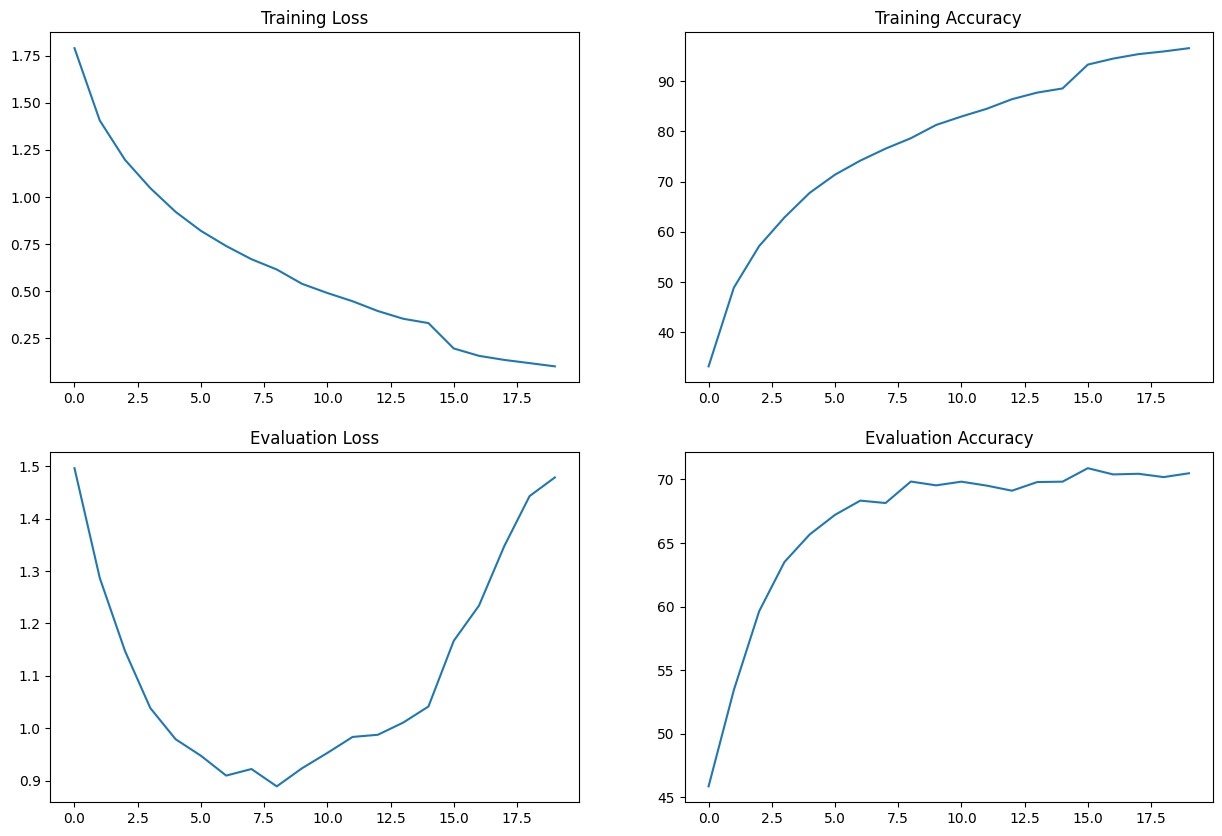

cuda
Train Epoch: 1	Loss: 1.727825, Accuracy: 36.67%
Eval Epoch: 1	Loss: 1.455170, Accuracy: 46.76%
Train Epoch: 2	Loss: 1.373431, Accuracy: 50.51%
Eval Epoch: 2	Loss: 1.322319, Accuracy: 51.99%
Train Epoch: 3	Loss: 1.182746, Accuracy: 57.87%
Eval Epoch: 3	Loss: 1.191107, Accuracy: 56.88%
Train Epoch: 4	Loss: 1.042762, Accuracy: 62.83%
Eval Epoch: 4	Loss: 1.039748, Accuracy: 63.59%
Train Epoch: 5	Loss: 0.929725, Accuracy: 67.23%
Eval Epoch: 5	Loss: 0.995524, Accuracy: 65.25%
Train Epoch: 6	Loss: 0.839338, Accuracy: 70.46%
Eval Epoch: 6	Loss: 0.943019, Accuracy: 67.58%
Train Epoch: 7	Loss: 0.761446, Accuracy: 73.29%
Eval Epoch: 7	Loss: 0.910399, Accuracy: 68.22%
Train Epoch: 8	Loss: 0.696464, Accuracy: 75.73%
Eval Epoch: 8	Loss: 0.931219, Accuracy: 68.23%
Train Epoch: 9	Loss: 0.638604, Accuracy: 77.64%
Eval Epoch: 9	Loss: 0.955702, Accuracy: 67.06%
Train Epoch: 10	Loss: 0.590267, Accuracy: 79.53%
Eval Epoch: 10	Loss: 0.919846, Accuracy: 69.35%
Train Epoch: 11	Loss: 0.546067, Accuracy: 8

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▆▇▇▇▇▇███████████
eval_loss,█▆▅▃▂▁▁▁▂▁▁▁▂▂▂▄▄▅▆▆
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇█████
train_loss,█▆▆▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,69.31
eval_loss,1.31087
train_accuracy,94.34
train_loss,0.16266


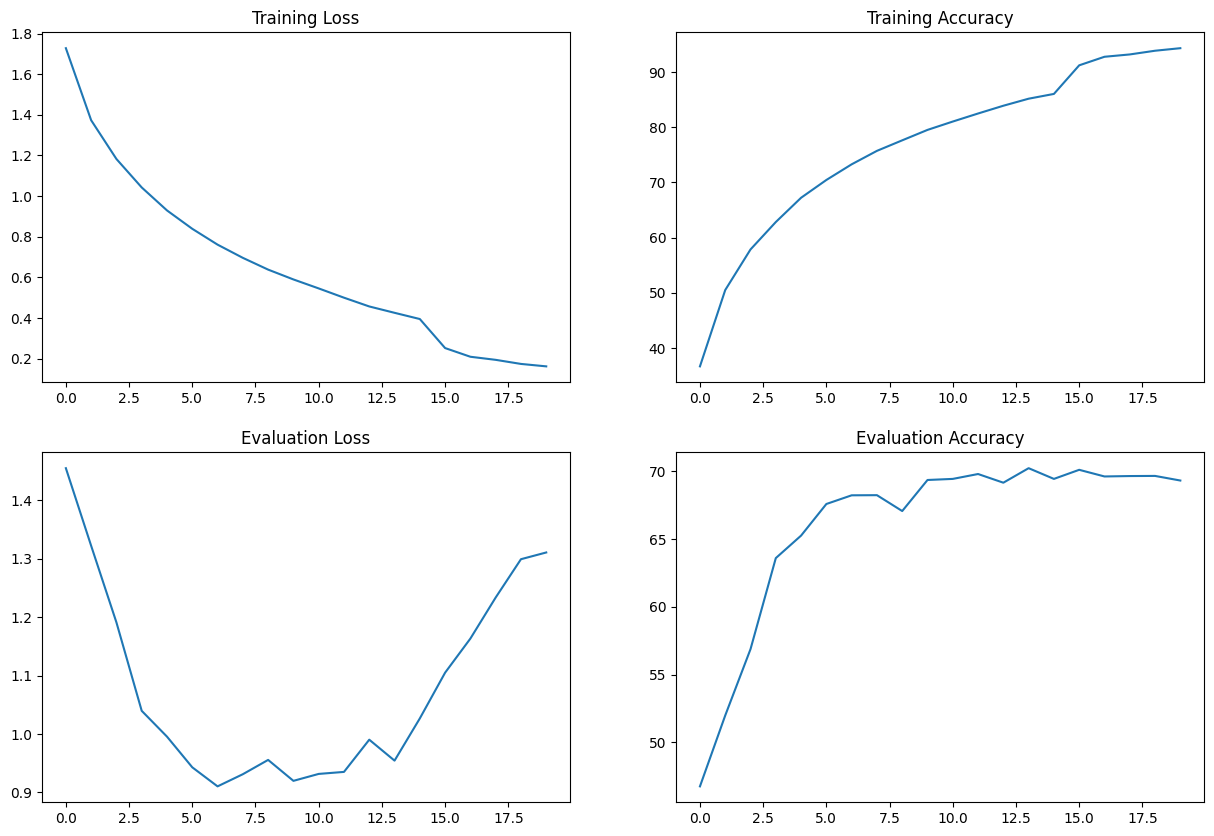

cuda
Train Epoch: 1	Loss: 1.879997, Accuracy: 29.60%
Eval Epoch: 1	Loss: 1.674903, Accuracy: 40.72%
Train Epoch: 2	Loss: 1.500237, Accuracy: 44.99%
Eval Epoch: 2	Loss: 1.388360, Accuracy: 49.51%
Train Epoch: 3	Loss: 1.326167, Accuracy: 52.27%
Eval Epoch: 3	Loss: 1.251454, Accuracy: 55.58%
Train Epoch: 4	Loss: 1.174963, Accuracy: 58.00%
Eval Epoch: 4	Loss: 1.197207, Accuracy: 58.59%
Train Epoch: 5	Loss: 1.077752, Accuracy: 61.95%
Eval Epoch: 5	Loss: 1.077121, Accuracy: 62.23%
Train Epoch: 6	Loss: 0.989226, Accuracy: 65.34%
Eval Epoch: 6	Loss: 0.988087, Accuracy: 65.19%
Train Epoch: 7	Loss: 0.881049, Accuracy: 69.26%
Eval Epoch: 7	Loss: 0.995971, Accuracy: 65.33%
Train Epoch: 8	Loss: 0.810987, Accuracy: 71.71%
Eval Epoch: 8	Loss: 0.933789, Accuracy: 68.05%
Train Epoch: 9	Loss: 0.761196, Accuracy: 73.45%
Eval Epoch: 9	Loss: 0.993770, Accuracy: 66.10%
Train Epoch: 10	Loss: 0.773285, Accuracy: 73.43%
Eval Epoch: 10	Loss: 0.878485, Accuracy: 69.94%
Train Epoch: 11	Loss: 0.631047, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▆▆▆▇▇▇██████████
eval_loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▂▂▃▄▄▅
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇█████
train_loss,█▆▆▅▅▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁
epoch,20
eval_accuracy,72.36
eval_loss,1.28309
train_accuracy,95.198
train_loss,0.138


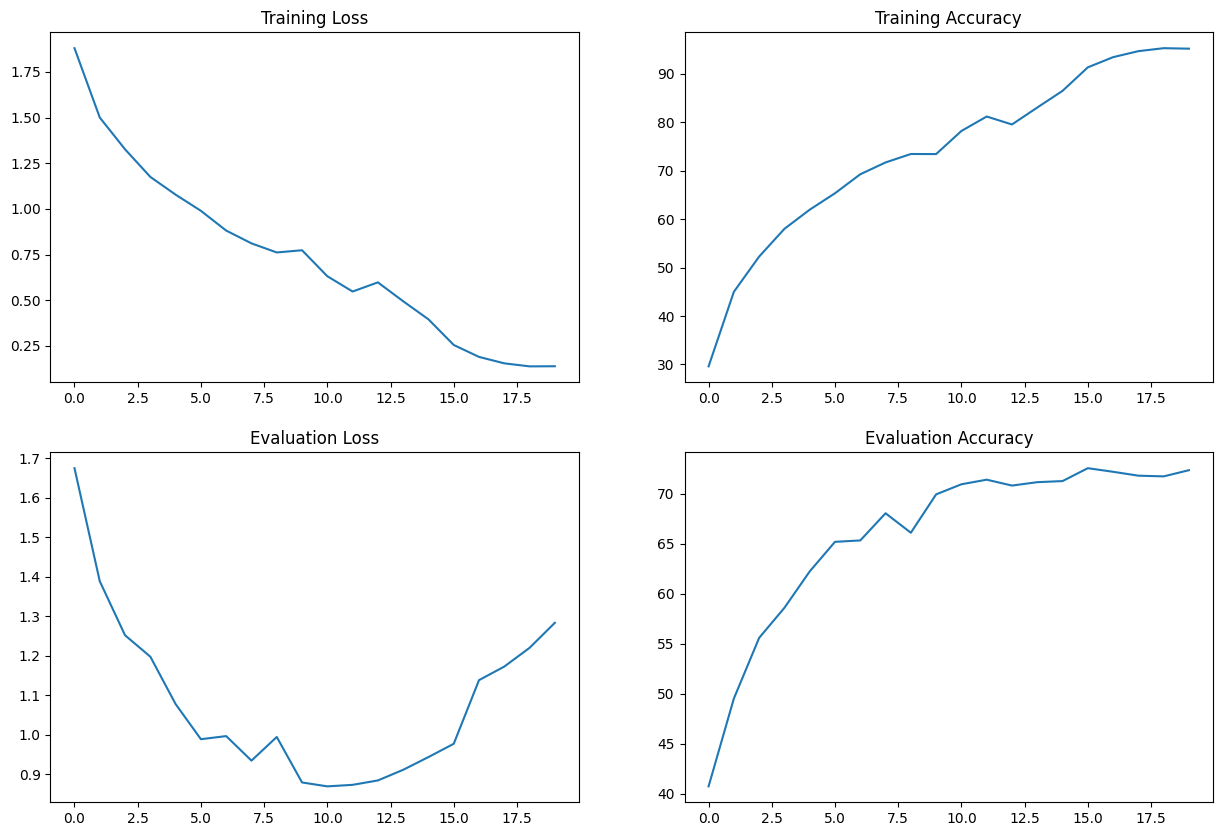

cuda
Train Epoch: 1	Loss: 1.937213, Accuracy: 26.28%
Eval Epoch: 1	Loss: 1.688032, Accuracy: 37.61%
Train Epoch: 2	Loss: 1.548827, Accuracy: 42.54%
Eval Epoch: 2	Loss: 1.466904, Accuracy: 47.28%
Train Epoch: 3	Loss: 1.353538, Accuracy: 50.80%
Eval Epoch: 3	Loss: 1.276335, Accuracy: 54.26%
Train Epoch: 4	Loss: 1.191108, Accuracy: 57.42%
Eval Epoch: 4	Loss: 1.164318, Accuracy: 58.46%
Train Epoch: 5	Loss: 1.108538, Accuracy: 60.87%
Eval Epoch: 5	Loss: 1.202775, Accuracy: 58.70%
Train Epoch: 6	Loss: 1.031889, Accuracy: 63.77%
Eval Epoch: 6	Loss: 1.040766, Accuracy: 63.66%
Train Epoch: 7	Loss: 0.920360, Accuracy: 67.68%
Eval Epoch: 7	Loss: 1.155893, Accuracy: 65.44%
Train Epoch: 8	Loss: 0.855541, Accuracy: 70.04%
Eval Epoch: 8	Loss: 1.016243, Accuracy: 65.44%
Train Epoch: 9	Loss: 0.779744, Accuracy: 72.85%
Eval Epoch: 9	Loss: 0.875152, Accuracy: 69.85%
Train Epoch: 10	Loss: 0.715253, Accuracy: 75.27%
Eval Epoch: 10	Loss: 1.101257, Accuracy: 70.24%
Train Epoch: 11	Loss: 0.642188, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▅▅▆▇▇▇▇█▇████████
eval_loss,▄▄▃▂▂▂▂▂▁▂▁█▄▅▂▂▂▃▃▄
train_accuracy,▁▃▄▄▅▅▅▆▆▆▆▇▇▇▇█████
train_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
epoch,20
eval_accuracy,71.51
eval_loss,1.46714
train_accuracy,93.75
train_loss,0.17894


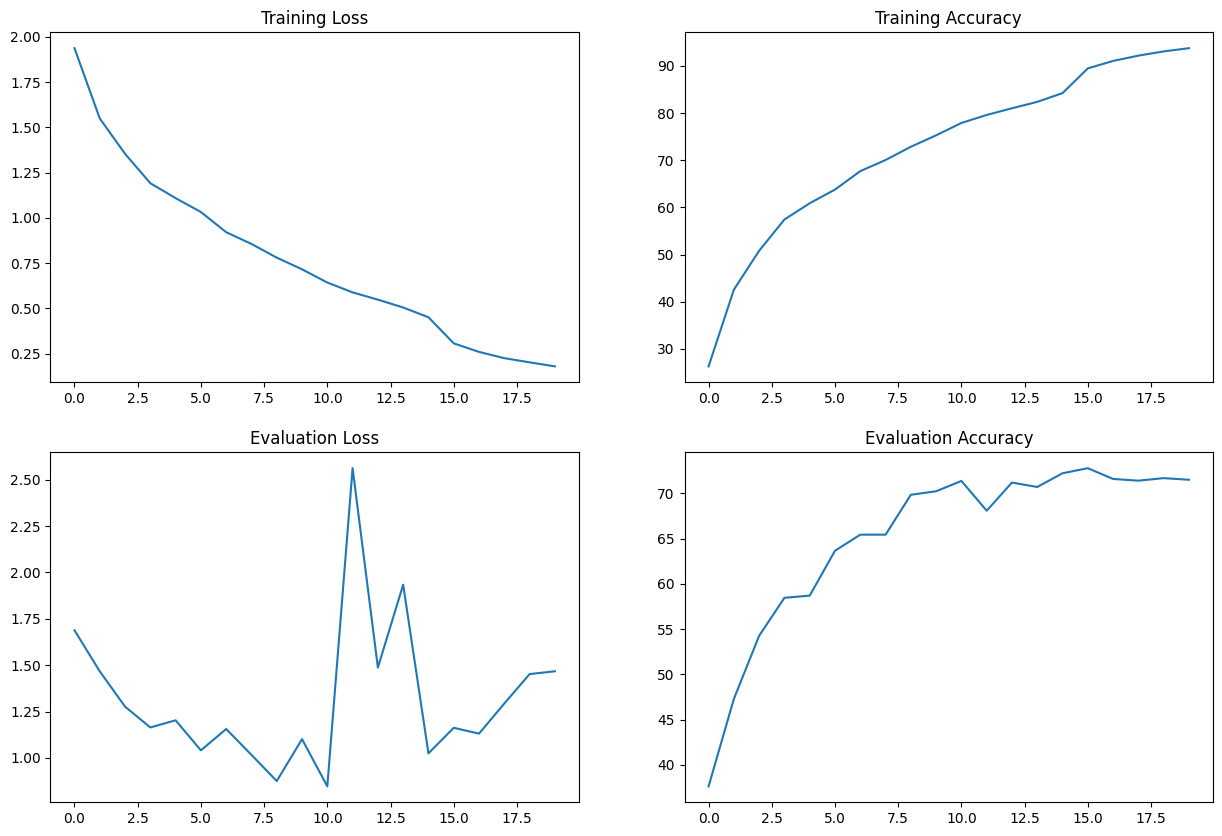

In [ ]:
activation_functions = [nn.ReLU6, nn.SiLU, nn.LeakyReLU, nn.Hardswish]
block_types = ["Regular", "SE"]
configs = [configA, configB]

for activation_function in activation_functions:
    for block_type in block_types:
        for config in configs:
            create_model(arch_expansion10, activation_function, block_type, config, train_loader, test_loader)

## 3

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def main3(model, config, train_loader, test_loader, exp_name):
    with wandb.init(project="arch_3", config=config, name=exp_name) as run:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        print(device)
        if config["optimizer"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config.get('weight_decay', 0))

        scheduler = StepLR(optimizer, step_size=config["scheduler_step_size"], gamma= config['scheduler_gamma'])

        train_losses, train_accuracy = [], []
        test_losses, test_accuracy = [], []

        for epoch in range(1, config["epochs"] + 1):
            train_model(model, device, train_loader, optimizer, epoch, train_losses, train_accuracy)
            evaluate_model(model, device, test_loader, epoch, test_losses, test_accuracy)
            scheduler.step()

        torch.save(model.state_dict(), f'{exp_name}_state_dict.pth')

    plot_metrics(train_losses, train_accuracy, test_losses, test_accuracy)

In [44]:
config = {
    "num_classes": 10,
    "learning_rate": 0.001,
    "epochs": 20,
    "optimizer": "Adam",
    "weight_decay": 1e-4,
    "dropout_rate": 0.3,
    "scheduler_step_size": 10,
    "scheduler_gamma": 0.7,
    "first_layer_channels": 32,
    "expansion_layer_channels": 1280
}

In [50]:
def create_model(arch, block_type,activation_function, config, train_loader, test_loader):
  if block_type == "Regular":
      model = CustomMobileNetV2(
          num_classes=config["num_classes"],
          inverted_block_configs=arch,
          first_layer_channels=config["first_layer_channels"],
          expansion_layer_channels=config["expansion_layer_channels"],
          dropout_rate=config.get("dropout_rate", 0.0),
          activation=activation_function
      )
  elif block_type == "SE":
      model = CustomMobileNetV2SE(
          num_classes=config["num_classes"],
          inverted_block_configs=arch,
          first_layer_channels=config["first_layer_channels"],
          expansion_layer_channels=config["expansion_layer_channels"],
          dropout_rate=config.get("dropout_rate", 0.0),
          activation=activation_function
      )

  exp_name = f"{activation_function.__name__}_{'original' if arch == original_architecture else 'expansion10'}_{block_type}"
  main3(model, config, train_loader, test_loader, exp_name)

In [51]:
arch_expansion10 = [dict(layer, expand_ratio=10 if layer['expand_ratio'] == 6 else layer['expand_ratio']) for layer in original_architecture]

cuda
Train Epoch: 1	Loss: 1.969005, Accuracy: 26.16%
Eval Epoch: 1	Loss: 1.721413, Accuracy: 35.22%
Train Epoch: 2	Loss: 1.675286, Accuracy: 37.79%
Eval Epoch: 2	Loss: 1.593404, Accuracy: 39.54%
Train Epoch: 3	Loss: 1.529341, Accuracy: 43.76%
Eval Epoch: 3	Loss: 1.477466, Accuracy: 45.20%
Train Epoch: 4	Loss: 1.419889, Accuracy: 48.49%
Eval Epoch: 4	Loss: 1.386755, Accuracy: 49.67%
Train Epoch: 5	Loss: 1.327501, Accuracy: 52.36%
Eval Epoch: 5	Loss: 1.280690, Accuracy: 53.95%
Train Epoch: 6	Loss: 1.231120, Accuracy: 56.08%
Eval Epoch: 6	Loss: 1.223601, Accuracy: 56.40%
Train Epoch: 7	Loss: 1.152693, Accuracy: 59.08%
Eval Epoch: 7	Loss: 1.153069, Accuracy: 58.67%
Train Epoch: 8	Loss: 1.090920, Accuracy: 61.27%
Eval Epoch: 8	Loss: 1.092670, Accuracy: 61.76%
Train Epoch: 9	Loss: 1.047896, Accuracy: 62.98%
Eval Epoch: 9	Loss: 1.027728, Accuracy: 64.14%
Train Epoch: 10	Loss: 1.001964, Accuracy: 64.69%
Eval Epoch: 10	Loss: 1.005116, Accuracy: 64.43%
Train Epoch: 11	Loss: 0.932900, Accuracy: 6

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇█████
eval_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_loss,█▆▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,73.52
eval_loss,0.76577
train_accuracy,74.886
train_loss,0.72563


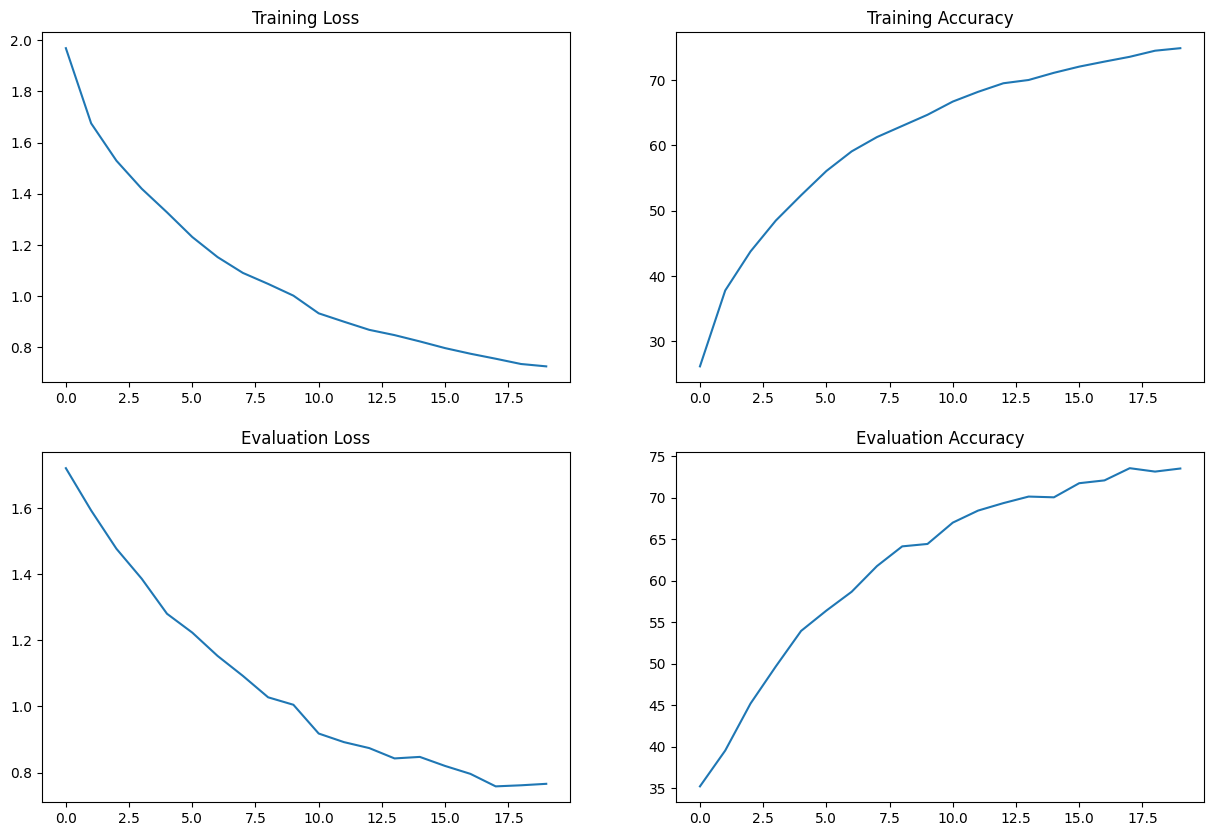

cuda
Train Epoch: 1	Loss: 2.006502, Accuracy: 24.44%
Eval Epoch: 1	Loss: 1.788268, Accuracy: 32.61%
Train Epoch: 2	Loss: 1.687413, Accuracy: 36.97%
Eval Epoch: 2	Loss: 1.601147, Accuracy: 40.37%
Train Epoch: 3	Loss: 1.537470, Accuracy: 43.61%
Eval Epoch: 3	Loss: 1.458909, Accuracy: 46.00%
Train Epoch: 4	Loss: 1.414610, Accuracy: 48.51%
Eval Epoch: 4	Loss: 1.403506, Accuracy: 48.74%
Train Epoch: 5	Loss: 1.320515, Accuracy: 52.63%
Eval Epoch: 5	Loss: 1.273237, Accuracy: 54.03%
Train Epoch: 6	Loss: 1.238464, Accuracy: 55.79%
Eval Epoch: 6	Loss: 1.236138, Accuracy: 55.25%
Train Epoch: 7	Loss: 1.178182, Accuracy: 58.33%
Eval Epoch: 7	Loss: 1.148414, Accuracy: 59.08%
Train Epoch: 8	Loss: 1.105739, Accuracy: 60.78%
Eval Epoch: 8	Loss: 1.118439, Accuracy: 60.71%
Train Epoch: 9	Loss: 1.054799, Accuracy: 62.67%
Eval Epoch: 9	Loss: 1.045128, Accuracy: 63.24%
Train Epoch: 10	Loss: 1.005477, Accuracy: 64.67%
Eval Epoch: 10	Loss: 0.990269, Accuracy: 64.92%
Train Epoch: 11	Loss: 0.937267, Accuracy: 6

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▅▅▆▆▆▇▇▇▇▇██████
eval_loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,73.0
eval_loss,0.78448
train_accuracy,74.958
train_loss,0.72082


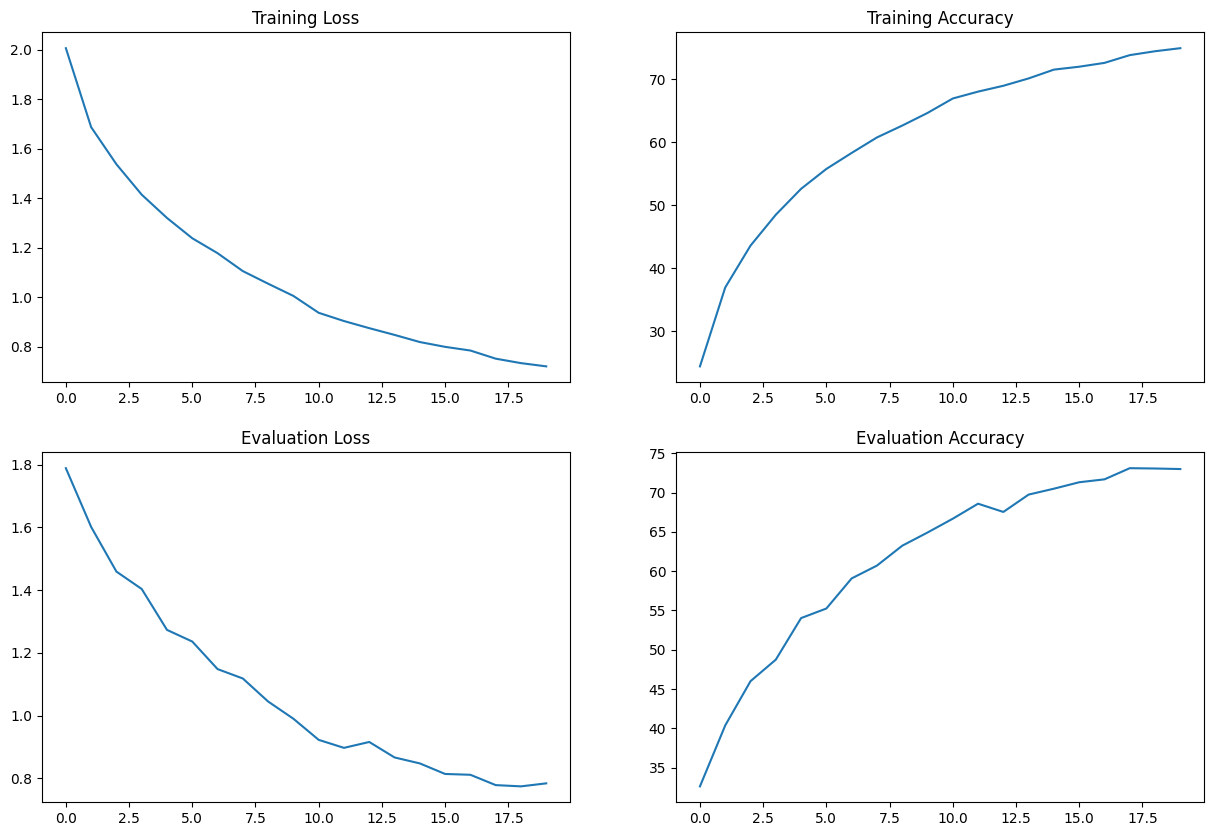

cuda
Train Epoch: 1	Loss: 1.888056, Accuracy: 29.65%
Eval Epoch: 1	Loss: 1.615759, Accuracy: 40.56%
Train Epoch: 2	Loss: 1.563588, Accuracy: 42.64%
Eval Epoch: 2	Loss: 1.514599, Accuracy: 45.69%
Train Epoch: 3	Loss: 1.427976, Accuracy: 48.27%
Eval Epoch: 3	Loss: 1.361610, Accuracy: 50.31%
Train Epoch: 4	Loss: 1.317893, Accuracy: 52.71%
Eval Epoch: 4	Loss: 1.256000, Accuracy: 55.45%
Train Epoch: 5	Loss: 1.225656, Accuracy: 56.43%
Eval Epoch: 5	Loss: 1.182245, Accuracy: 58.50%
Train Epoch: 6	Loss: 1.136826, Accuracy: 59.40%
Eval Epoch: 6	Loss: 1.123995, Accuracy: 59.51%
Train Epoch: 7	Loss: 1.094353, Accuracy: 61.29%
Eval Epoch: 7	Loss: 1.058444, Accuracy: 62.85%
Train Epoch: 8	Loss: 1.013961, Accuracy: 64.27%
Eval Epoch: 8	Loss: 0.973833, Accuracy: 66.34%
Train Epoch: 9	Loss: 0.953836, Accuracy: 66.70%
Eval Epoch: 9	Loss: 0.921449, Accuracy: 67.98%
Train Epoch: 10	Loss: 0.903296, Accuracy: 68.53%
Eval Epoch: 10	Loss: 0.972855, Accuracy: 66.70%
Train Epoch: 11	Loss: 0.826278, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇██████
eval_loss,█▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
epoch,20
eval_accuracy,76.6
eval_loss,0.68839
train_accuracy,78.154
train_loss,0.63251


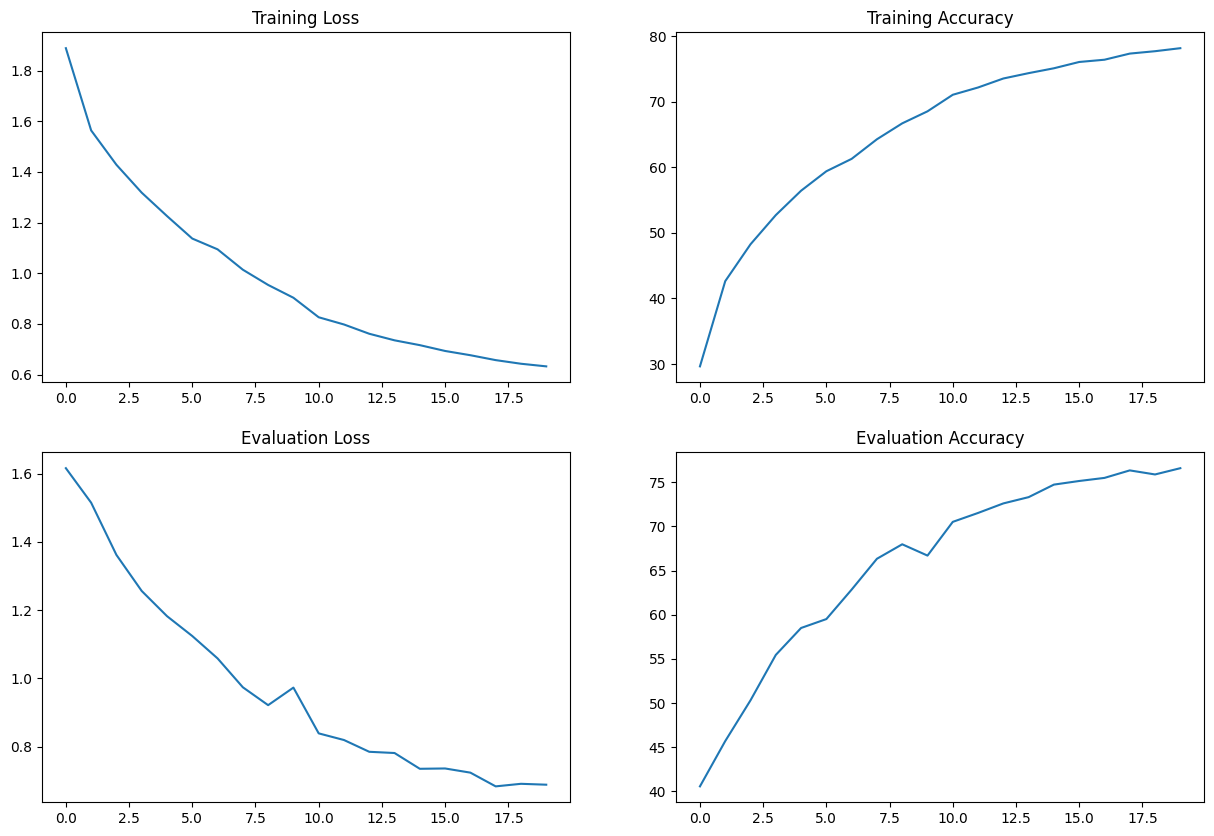

cuda
Train Epoch: 1	Loss: 1.887801, Accuracy: 28.41%
Eval Epoch: 1	Loss: 1.629911, Accuracy: 39.47%
Train Epoch: 2	Loss: 1.593921, Accuracy: 40.32%
Eval Epoch: 2	Loss: 1.541598, Accuracy: 42.82%
Train Epoch: 3	Loss: 1.473184, Accuracy: 46.05%
Eval Epoch: 3	Loss: 1.401156, Accuracy: 49.53%
Train Epoch: 4	Loss: 1.377557, Accuracy: 49.93%
Eval Epoch: 4	Loss: 1.289691, Accuracy: 53.53%
Train Epoch: 5	Loss: 1.268597, Accuracy: 54.88%
Eval Epoch: 5	Loss: 1.227811, Accuracy: 56.00%
Train Epoch: 6	Loss: 1.169099, Accuracy: 58.30%
Eval Epoch: 6	Loss: 1.157054, Accuracy: 59.06%
Train Epoch: 7	Loss: 1.097868, Accuracy: 61.43%
Eval Epoch: 7	Loss: 1.101486, Accuracy: 61.24%
Train Epoch: 8	Loss: 1.030807, Accuracy: 63.40%
Eval Epoch: 8	Loss: 1.000792, Accuracy: 65.27%
Train Epoch: 9	Loss: 0.967777, Accuracy: 65.95%
Eval Epoch: 9	Loss: 0.970293, Accuracy: 66.06%
Train Epoch: 10	Loss: 0.916161, Accuracy: 67.84%
Eval Epoch: 10	Loss: 0.924600, Accuracy: 67.41%
Train Epoch: 11	Loss: 0.826227, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▄▅▅▆▆▆▇▇▇▇██████
eval_loss,█▇▆▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▃▃▄▅▅▆▆▆▆▇▇▇▇██████
train_loss,█▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,77.4
eval_loss,0.66285
train_accuracy,78.68
train_loss,0.61737


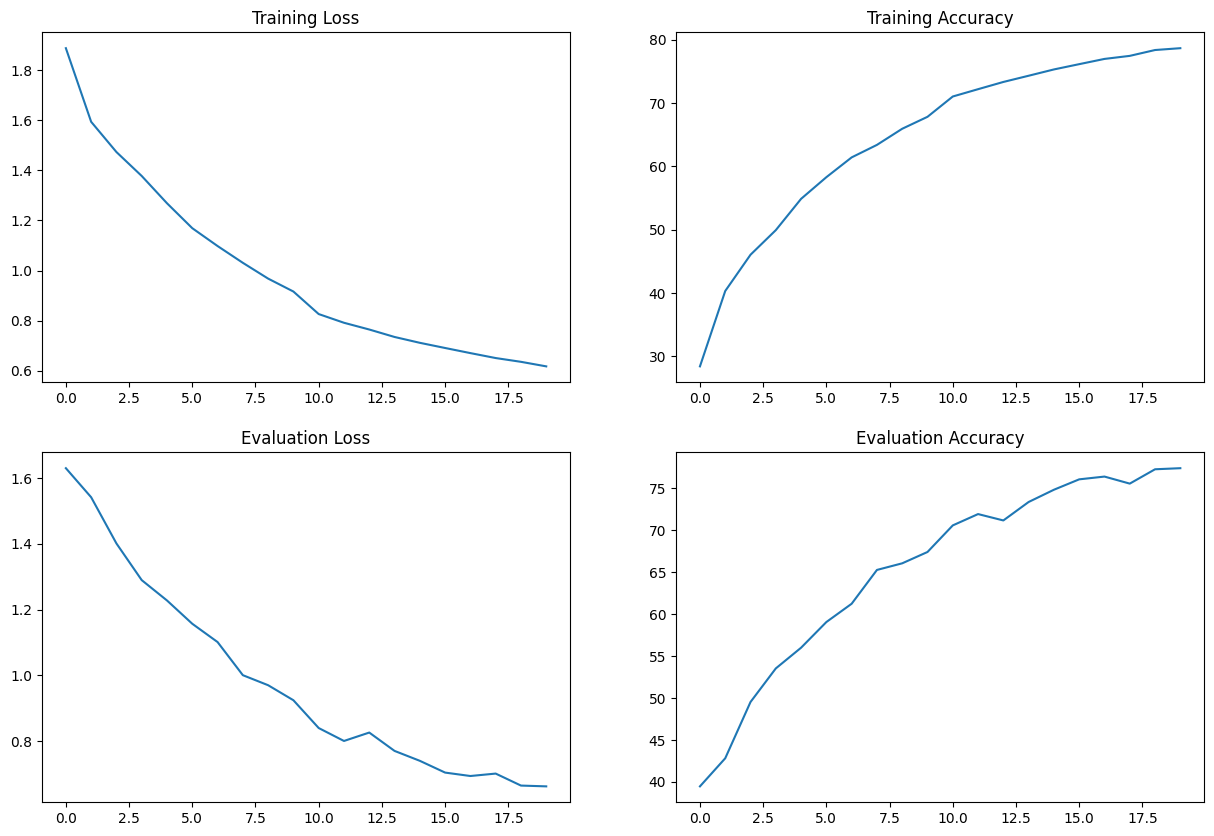

cuda
Train Epoch: 1	Loss: 1.815371, Accuracy: 31.89%
Eval Epoch: 1	Loss: 1.554573, Accuracy: 41.52%
Train Epoch: 2	Loss: 1.500288, Accuracy: 45.30%
Eval Epoch: 2	Loss: 1.490571, Accuracy: 45.87%
Train Epoch: 3	Loss: 1.349478, Accuracy: 51.27%
Eval Epoch: 3	Loss: 1.283390, Accuracy: 53.92%
Train Epoch: 4	Loss: 1.224690, Accuracy: 56.10%
Eval Epoch: 4	Loss: 1.175948, Accuracy: 58.52%
Train Epoch: 5	Loss: 1.131965, Accuracy: 59.56%
Eval Epoch: 5	Loss: 1.113259, Accuracy: 60.06%
Train Epoch: 6	Loss: 1.040378, Accuracy: 63.10%
Eval Epoch: 6	Loss: 1.014292, Accuracy: 64.28%
Train Epoch: 7	Loss: 0.972430, Accuracy: 65.78%
Eval Epoch: 7	Loss: 0.938385, Accuracy: 67.29%
Train Epoch: 8	Loss: 0.922016, Accuracy: 67.44%
Eval Epoch: 8	Loss: 0.929551, Accuracy: 67.01%
Train Epoch: 9	Loss: 0.878240, Accuracy: 69.11%
Eval Epoch: 9	Loss: 0.874605, Accuracy: 69.25%
Train Epoch: 10	Loss: 0.842073, Accuracy: 70.69%
Eval Epoch: 10	Loss: 0.864043, Accuracy: 69.53%
Train Epoch: 11	Loss: 0.782376, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇█▇██████
eval_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
eval_accuracy,76.71
eval_loss,0.67152
train_accuracy,78.166
train_loss,0.63334


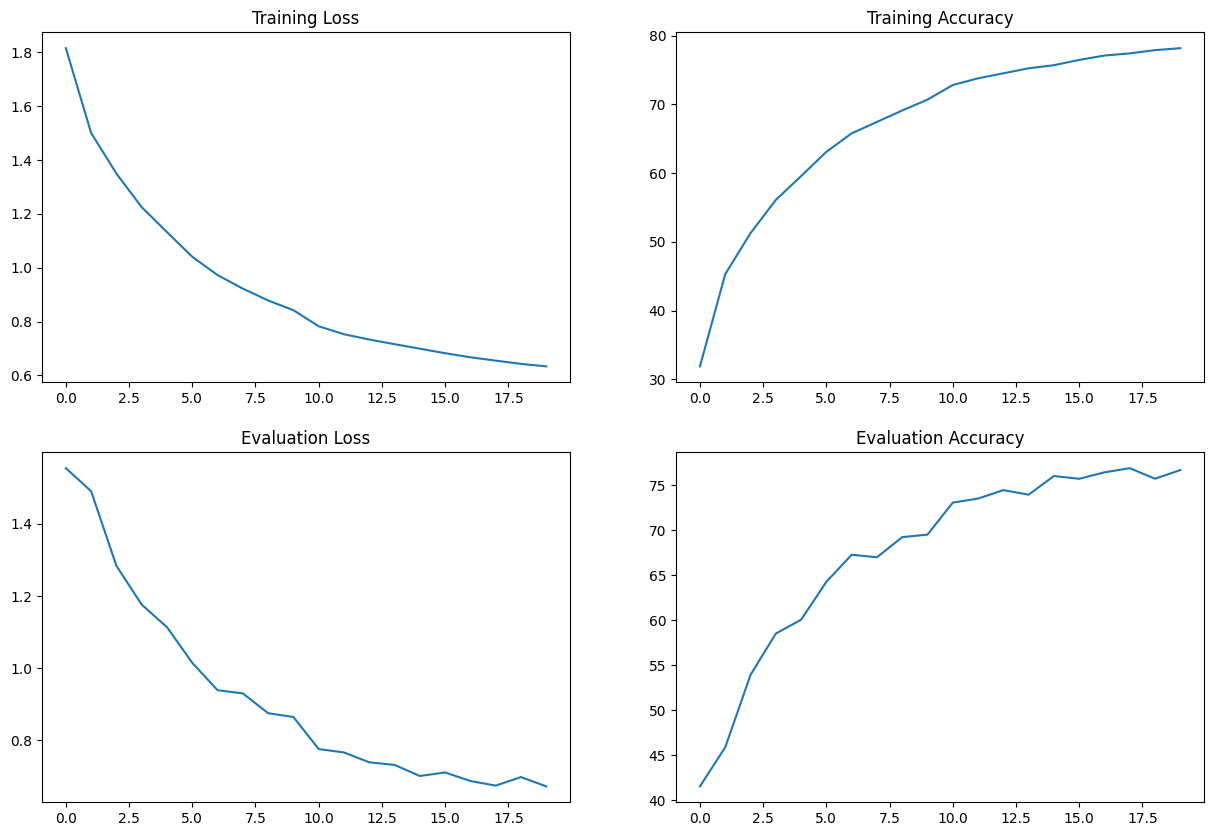

cuda
Train Epoch: 1	Loss: 1.948024, Accuracy: 26.90%
Eval Epoch: 1	Loss: 1.716641, Accuracy: 35.57%
Train Epoch: 2	Loss: 1.615444, Accuracy: 39.99%
Eval Epoch: 2	Loss: 1.489512, Accuracy: 43.69%
Train Epoch: 3	Loss: 1.455683, Accuracy: 46.48%
Eval Epoch: 3	Loss: 1.389186, Accuracy: 48.67%
Train Epoch: 4	Loss: 1.340953, Accuracy: 50.98%
Eval Epoch: 4	Loss: 1.281737, Accuracy: 53.93%
Train Epoch: 5	Loss: 1.239896, Accuracy: 55.33%
Eval Epoch: 5	Loss: 1.224314, Accuracy: 56.26%
Train Epoch: 6	Loss: 1.153016, Accuracy: 58.59%
Eval Epoch: 6	Loss: 1.115014, Accuracy: 60.58%
Train Epoch: 7	Loss: 1.089726, Accuracy: 61.25%
Eval Epoch: 7	Loss: 1.044876, Accuracy: 63.02%
Train Epoch: 8	Loss: 1.015169, Accuracy: 64.15%
Eval Epoch: 8	Loss: 1.018126, Accuracy: 63.47%
Train Epoch: 9	Loss: 0.955064, Accuracy: 66.28%
Eval Epoch: 9	Loss: 0.924908, Accuracy: 67.71%
Train Epoch: 10	Loss: 0.905265, Accuracy: 68.14%
Eval Epoch: 10	Loss: 0.904751, Accuracy: 67.60%
Train Epoch: 11	Loss: 0.830204, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇██████
eval_loss,█▆▆▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
eval_accuracy,76.82
eval_loss,0.67437
train_accuracy,77.45
train_loss,0.64958


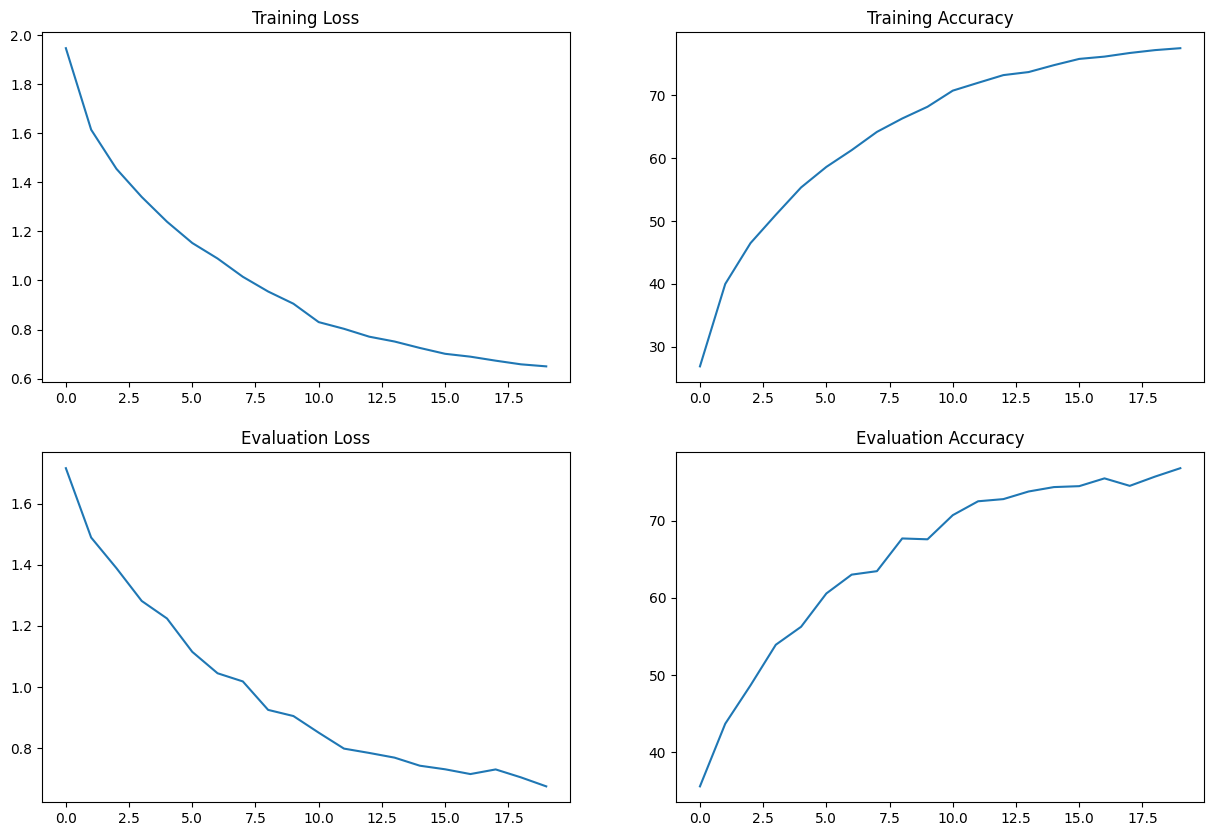

cuda
Train Epoch: 1	Loss: 1.776701, Accuracy: 34.31%
Eval Epoch: 1	Loss: 1.575124, Accuracy: 41.54%
Train Epoch: 2	Loss: 1.489331, Accuracy: 45.66%
Eval Epoch: 2	Loss: 1.381262, Accuracy: 50.12%
Train Epoch: 3	Loss: 1.329654, Accuracy: 52.35%
Eval Epoch: 3	Loss: 1.256794, Accuracy: 55.04%
Train Epoch: 4	Loss: 1.183724, Accuracy: 57.69%
Eval Epoch: 4	Loss: 1.149454, Accuracy: 58.73%
Train Epoch: 5	Loss: 1.078375, Accuracy: 61.71%
Eval Epoch: 5	Loss: 1.086690, Accuracy: 61.36%
Train Epoch: 6	Loss: 1.006658, Accuracy: 64.32%
Eval Epoch: 6	Loss: 0.960835, Accuracy: 65.63%
Train Epoch: 7	Loss: 0.940234, Accuracy: 66.53%
Eval Epoch: 7	Loss: 0.927705, Accuracy: 67.28%
Train Epoch: 8	Loss: 0.887652, Accuracy: 68.64%
Eval Epoch: 8	Loss: 0.895654, Accuracy: 68.61%
Train Epoch: 9	Loss: 0.836068, Accuracy: 70.69%
Eval Epoch: 9	Loss: 0.856053, Accuracy: 70.29%
Train Epoch: 10	Loss: 0.799021, Accuracy: 72.21%
Eval Epoch: 10	Loss: 0.900610, Accuracy: 70.55%
Train Epoch: 11	Loss: 0.733128, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇██████
eval_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
eval_accuracy,79.24
eval_loss,0.60833
train_accuracy,79.942
train_loss,0.5754


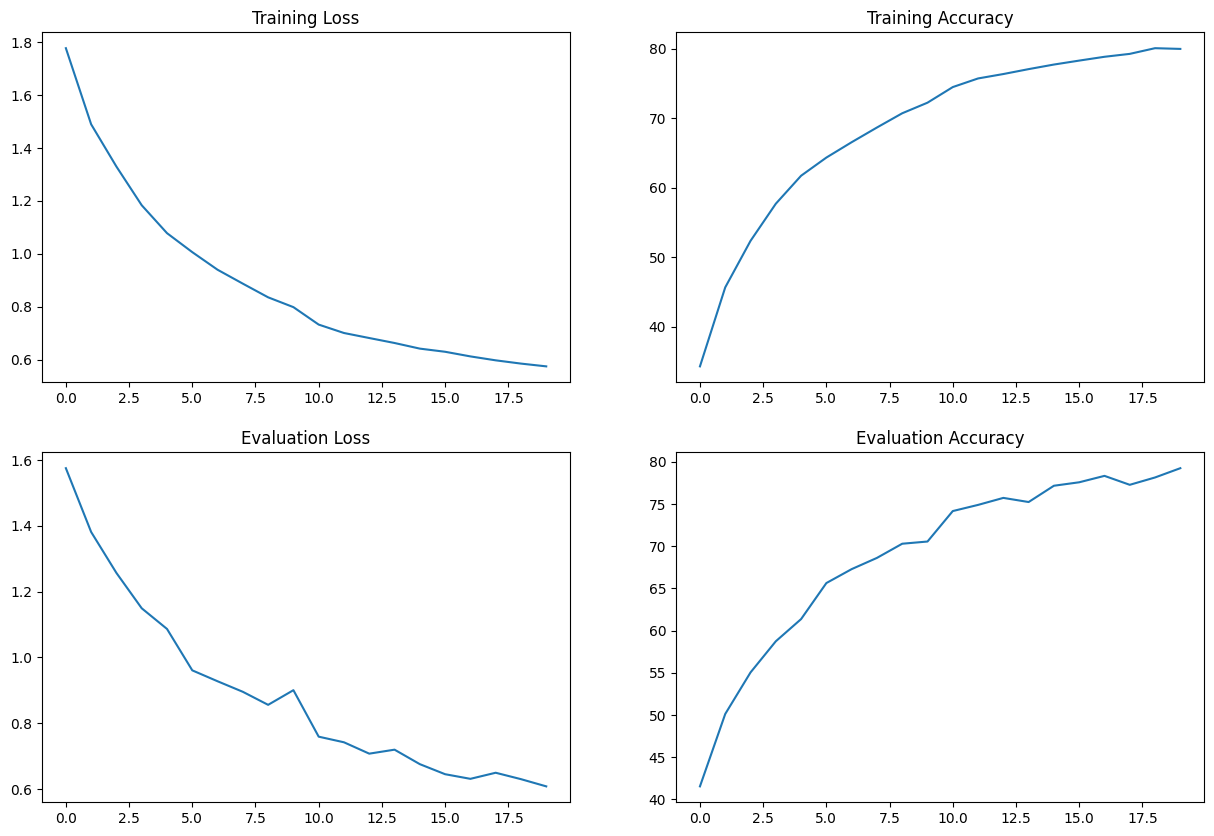

cuda
Train Epoch: 1	Loss: 1.878431, Accuracy: 28.01%
Eval Epoch: 1	Loss: 1.629501, Accuracy: 39.23%
Train Epoch: 2	Loss: 1.513399, Accuracy: 43.70%
Eval Epoch: 2	Loss: 1.406888, Accuracy: 47.49%
Train Epoch: 3	Loss: 1.329644, Accuracy: 51.94%
Eval Epoch: 3	Loss: 1.240994, Accuracy: 55.36%
Train Epoch: 4	Loss: 1.195782, Accuracy: 57.11%
Eval Epoch: 4	Loss: 1.123908, Accuracy: 59.44%
Train Epoch: 5	Loss: 1.086569, Accuracy: 61.33%
Eval Epoch: 5	Loss: 1.069075, Accuracy: 62.21%
Train Epoch: 6	Loss: 1.021709, Accuracy: 63.82%
Eval Epoch: 6	Loss: 1.187835, Accuracy: 59.03%
Train Epoch: 7	Loss: 0.975955, Accuracy: 65.73%
Eval Epoch: 7	Loss: 0.919995, Accuracy: 67.96%
Train Epoch: 8	Loss: 0.878920, Accuracy: 69.15%
Eval Epoch: 8	Loss: 0.868120, Accuracy: 69.64%
Train Epoch: 9	Loss: 0.824003, Accuracy: 71.36%
Eval Epoch: 9	Loss: 0.818626, Accuracy: 71.54%
Train Epoch: 10	Loss: 0.796804, Accuracy: 72.07%
Eval Epoch: 10	Loss: 0.987391, Accuracy: 71.27%
Train Epoch: 11	Loss: 0.715991, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▄▅▅▄▆▆▇▇▇▇▇██▇████
eval_loss,█▆▅▅▄▅▃▃▃▄▂▂▂▂▁▂▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
eval_accuracy,79.5
eval_loss,0.61007
train_accuracy,80.778
train_loss,0.5591


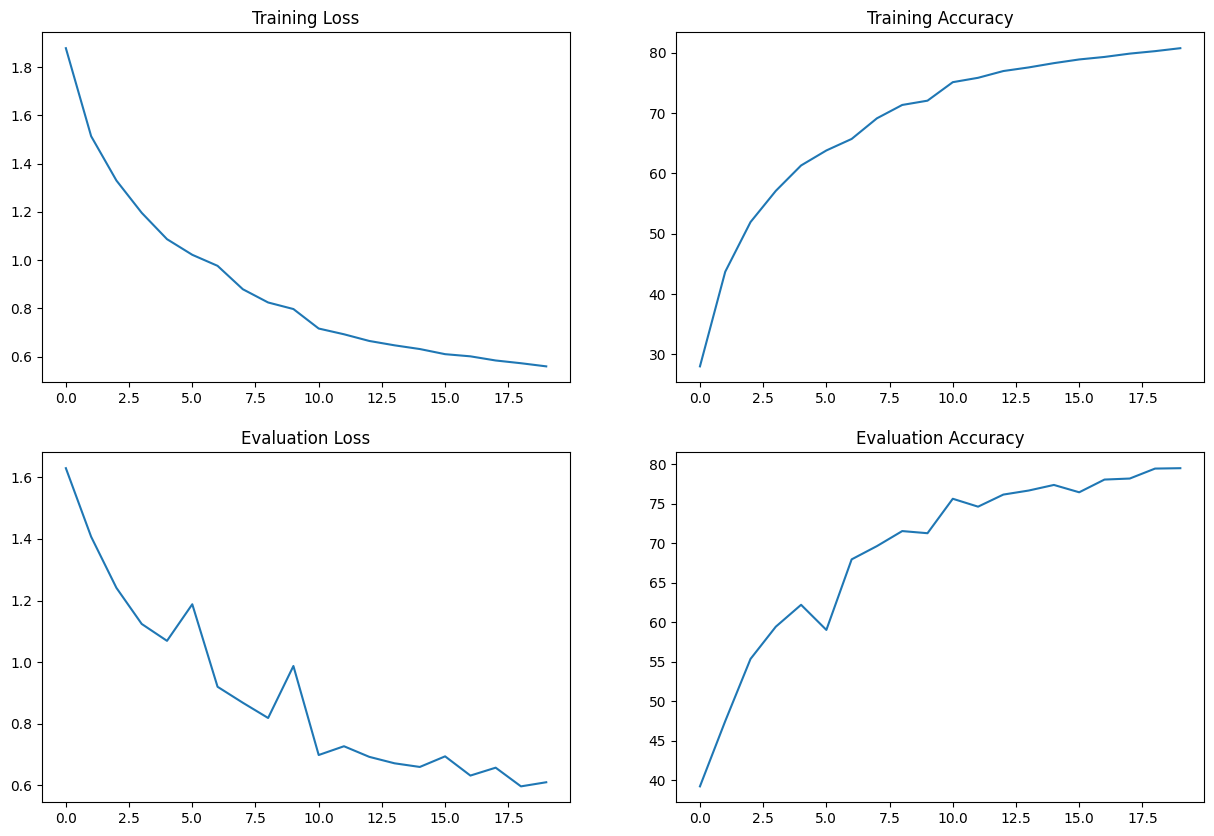

cuda
Train Epoch: 1	Loss: 1.875664, Accuracy: 29.33%
Eval Epoch: 1	Loss: 1.695551, Accuracy: 36.07%
Train Epoch: 2	Loss: 1.579209, Accuracy: 41.33%
Eval Epoch: 2	Loss: 1.472134, Accuracy: 45.49%
Train Epoch: 3	Loss: 1.448300, Accuracy: 47.02%
Eval Epoch: 3	Loss: 1.410085, Accuracy: 48.36%
Train Epoch: 4	Loss: 1.330111, Accuracy: 51.25%
Eval Epoch: 4	Loss: 1.295942, Accuracy: 52.76%
Train Epoch: 5	Loss: 1.219758, Accuracy: 55.93%
Eval Epoch: 5	Loss: 1.197391, Accuracy: 56.40%
Train Epoch: 6	Loss: 1.139867, Accuracy: 59.25%
Eval Epoch: 6	Loss: 1.102572, Accuracy: 60.72%
Train Epoch: 7	Loss: 1.072252, Accuracy: 61.90%
Eval Epoch: 7	Loss: 1.205177, Accuracy: 58.18%
Train Epoch: 8	Loss: 1.016790, Accuracy: 64.06%
Eval Epoch: 8	Loss: 1.008894, Accuracy: 64.74%
Train Epoch: 9	Loss: 0.962301, Accuracy: 66.04%
Eval Epoch: 9	Loss: 0.925728, Accuracy: 67.29%
Train Epoch: 10	Loss: 0.916124, Accuracy: 67.71%
Eval Epoch: 10	Loss: 0.906076, Accuracy: 68.29%
Train Epoch: 11	Loss: 0.849201, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▃▄▅▅▅▆▇▇▇▇▇▇██████
eval_loss,█▆▆▅▄▄▅▃▃▂▂▂▂▂▂▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch,20
eval_accuracy,75.45
eval_loss,0.71042
train_accuracy,76.236
train_loss,0.68716


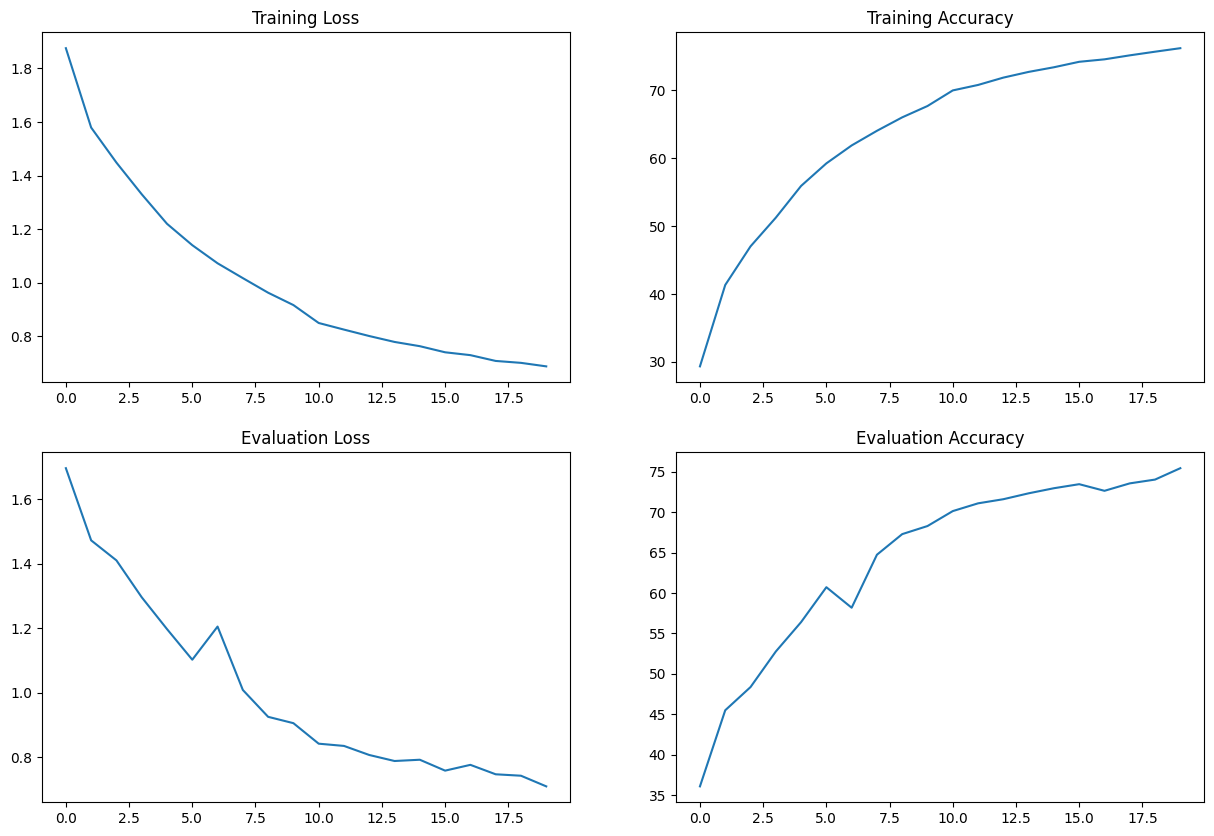

cuda
Train Epoch: 1	Loss: 2.014444, Accuracy: 23.85%
Eval Epoch: 1	Loss: 1.790964, Accuracy: 33.47%
Train Epoch: 2	Loss: 1.695284, Accuracy: 36.29%
Eval Epoch: 2	Loss: 1.590734, Accuracy: 39.90%
Train Epoch: 3	Loss: 1.552392, Accuracy: 42.24%
Eval Epoch: 3	Loss: 1.551214, Accuracy: 44.33%
Train Epoch: 4	Loss: 1.444471, Accuracy: 47.31%
Eval Epoch: 4	Loss: 1.406429, Accuracy: 47.89%
Train Epoch: 5	Loss: 1.347071, Accuracy: 51.03%
Eval Epoch: 5	Loss: 1.370413, Accuracy: 50.08%
Train Epoch: 6	Loss: 1.262681, Accuracy: 54.67%
Eval Epoch: 6	Loss: 1.237609, Accuracy: 55.87%
Train Epoch: 7	Loss: 1.199268, Accuracy: 57.01%
Eval Epoch: 7	Loss: 1.175510, Accuracy: 57.62%
Train Epoch: 8	Loss: 1.120789, Accuracy: 60.09%
Eval Epoch: 8	Loss: 1.118741, Accuracy: 60.58%
Train Epoch: 9	Loss: 1.088562, Accuracy: 61.18%
Eval Epoch: 9	Loss: 1.053949, Accuracy: 62.36%
Train Epoch: 10	Loss: 1.007989, Accuracy: 63.98%
Eval Epoch: 10	Loss: 1.011574, Accuracy: 65.06%
Train Epoch: 11	Loss: 0.935312, Accuracy: 6

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇████
eval_loss,█▇▆▅▅▄▄▄▃▃▂▃▃▂▃▂▁▁▁▁
train_accuracy,▁▃▃▄▅▅▅▆▆▆▇▇▇▇▇█████
train_loss,█▆▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,74.74
eval_loss,0.73794
train_accuracy,75.458
train_loss,0.70521


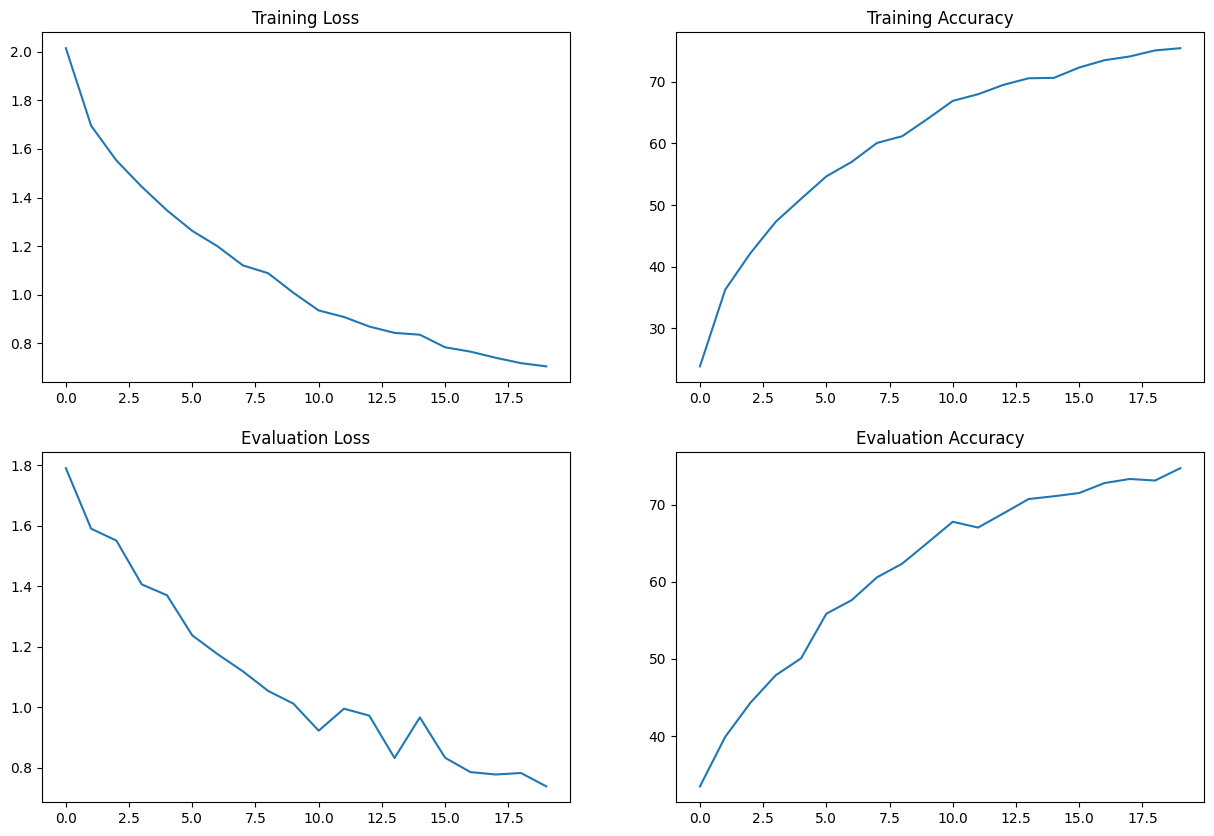

cuda
Train Epoch: 1	Loss: 1.838787, Accuracy: 31.52%
Eval Epoch: 1	Loss: 1.615316, Accuracy: 39.86%
Train Epoch: 2	Loss: 1.498915, Accuracy: 44.47%
Eval Epoch: 2	Loss: 1.441969, Accuracy: 46.94%
Train Epoch: 3	Loss: 1.316355, Accuracy: 52.37%
Eval Epoch: 3	Loss: 1.277029, Accuracy: 54.24%
Train Epoch: 4	Loss: 1.196721, Accuracy: 56.89%
Eval Epoch: 4	Loss: 1.159468, Accuracy: 57.75%
Train Epoch: 5	Loss: 1.107062, Accuracy: 60.47%
Eval Epoch: 5	Loss: 1.057405, Accuracy: 62.05%
Train Epoch: 6	Loss: 1.037726, Accuracy: 63.26%
Eval Epoch: 6	Loss: 1.002756, Accuracy: 63.97%
Train Epoch: 7	Loss: 0.969033, Accuracy: 65.48%
Eval Epoch: 7	Loss: 1.005256, Accuracy: 64.24%
Train Epoch: 8	Loss: 0.916140, Accuracy: 67.56%
Eval Epoch: 8	Loss: 0.885260, Accuracy: 69.40%
Train Epoch: 9	Loss: 0.871078, Accuracy: 69.35%
Eval Epoch: 9	Loss: 0.845085, Accuracy: 70.45%
Train Epoch: 10	Loss: 0.835840, Accuracy: 70.71%
Eval Epoch: 10	Loss: 0.844830, Accuracy: 70.59%
Train Epoch: 11	Loss: 0.761970, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▂▄▄▅▅▆▆▇▇▇▇▇███████
eval_loss,█▇▆▅▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇███████
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,20
eval_accuracy,77.21
eval_loss,0.65005
train_accuracy,78.892
train_loss,0.6114


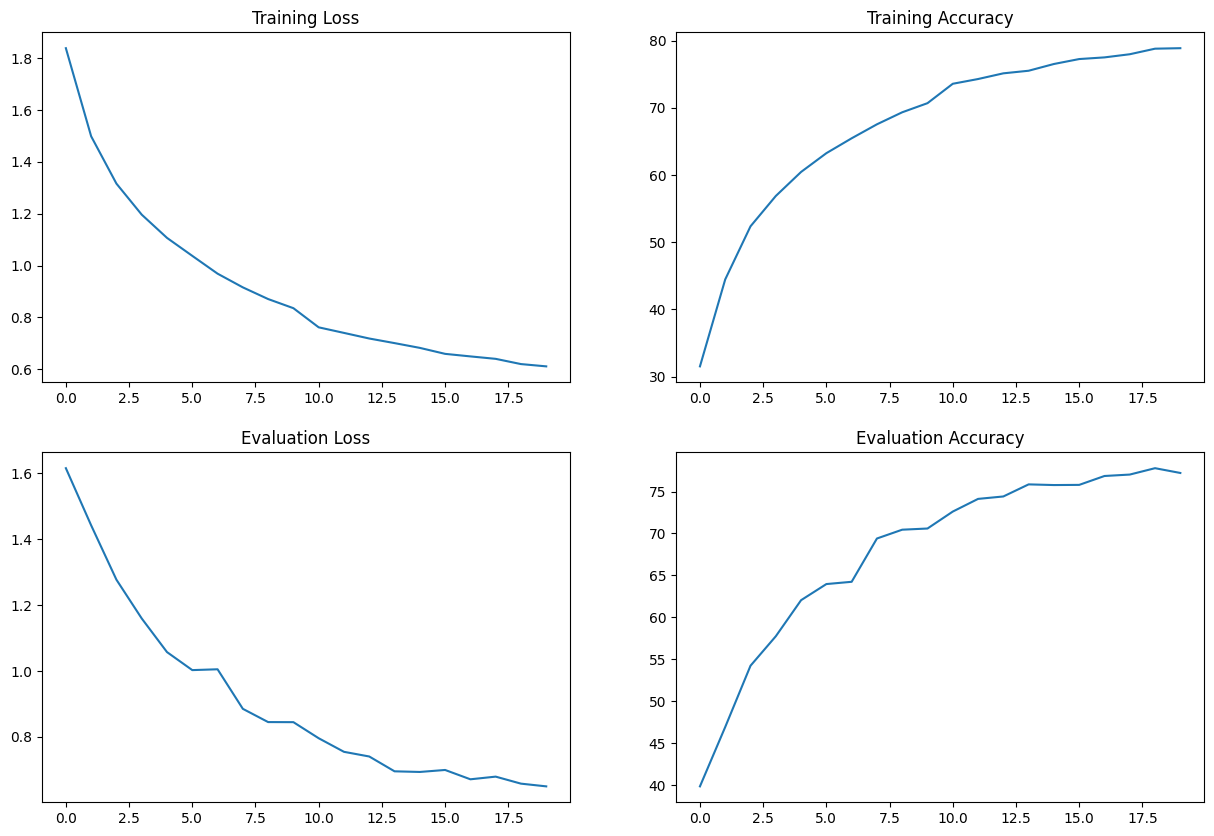

cuda
Train Epoch: 1	Loss: 2.020574, Accuracy: 23.19%
Eval Epoch: 1	Loss: 1.761206, Accuracy: 33.41%
Train Epoch: 2	Loss: 1.668193, Accuracy: 37.09%
Eval Epoch: 2	Loss: 1.525180, Accuracy: 43.07%
Train Epoch: 3	Loss: 1.484340, Accuracy: 45.01%
Eval Epoch: 3	Loss: 1.365517, Accuracy: 48.90%
Train Epoch: 4	Loss: 1.333499, Accuracy: 51.14%
Eval Epoch: 4	Loss: 1.234228, Accuracy: 55.26%
Train Epoch: 5	Loss: 1.213033, Accuracy: 56.25%
Eval Epoch: 5	Loss: 1.160844, Accuracy: 58.49%
Train Epoch: 6	Loss: 1.110217, Accuracy: 60.10%
Eval Epoch: 6	Loss: 1.069836, Accuracy: 61.87%
Train Epoch: 7	Loss: 1.055109, Accuracy: 62.49%
Eval Epoch: 7	Loss: 1.080396, Accuracy: 61.66%
Train Epoch: 8	Loss: 0.968739, Accuracy: 65.36%
Eval Epoch: 8	Loss: 0.947020, Accuracy: 66.59%
Train Epoch: 9	Loss: 0.921071, Accuracy: 67.42%
Eval Epoch: 9	Loss: 0.973631, Accuracy: 65.55%
Train Epoch: 10	Loss: 0.867052, Accuracy: 69.42%
Eval Epoch: 10	Loss: 0.867800, Accuracy: 69.36%
Train Epoch: 11	Loss: 0.791522, Accuracy: 7

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eval_accuracy,▁▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇████
eval_loss,█▇▆▅▄▄▄▃▃▂▂▂▂▂▃▂▁▁▁▁
train_accuracy,▁▃▄▄▅▆▆▆▇▇▇▇▇▇██████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,20
eval_accuracy,78.37
eval_loss,0.64581
train_accuracy,79.126
train_loss,0.59969


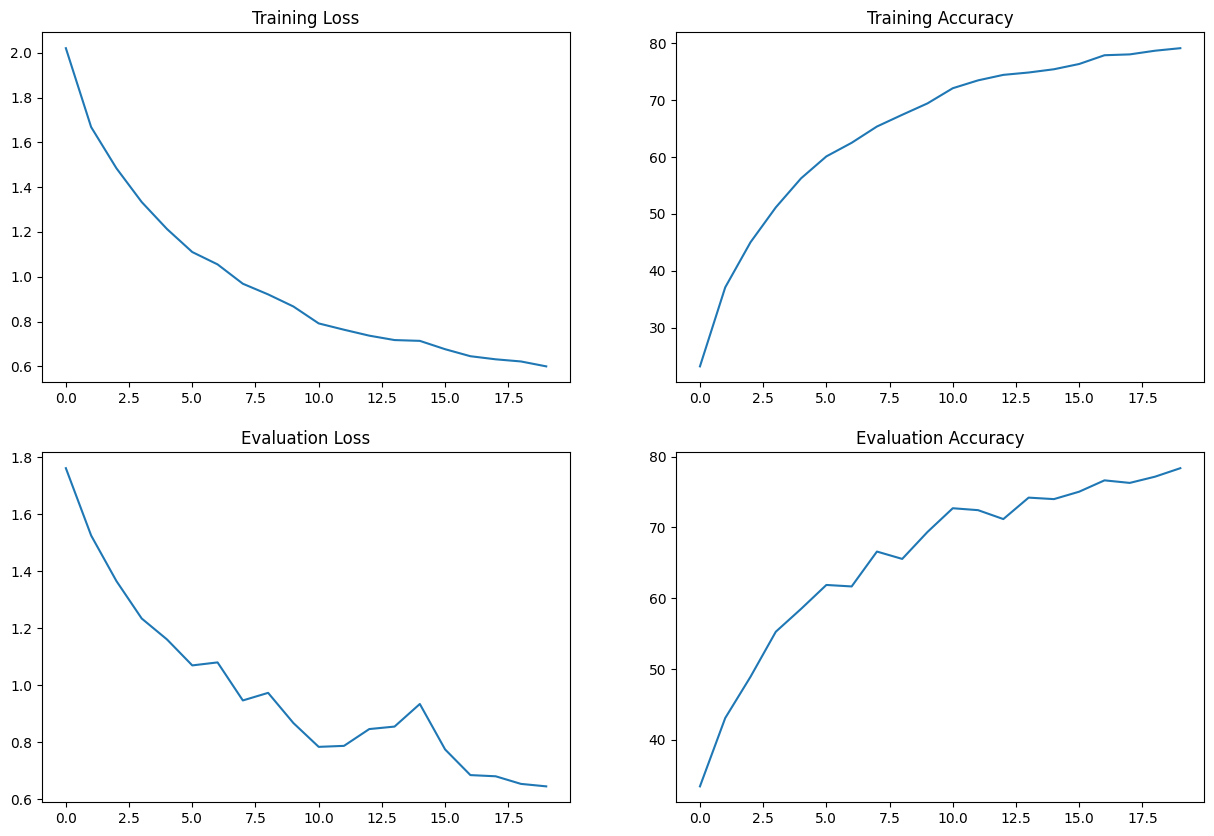

In [52]:
activation_functions = [nn.ReLU6, nn.SiLU, nn.Hardswish]
block_types = ["Regular", "SE"]
archs = [original_architecture, arch_expansion10]
for activation_function in activation_functions:
    for arch in archs:
        for block_type in block_types:
          create_model(arch, block_type, activation_function, config, trainloader, testloader)